In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading req

In [2]:
library("viridis")

Loading required package: viridisLite



In [3]:
library(ComplexUpset)

In [4]:
library(ggrepel)

In [5]:
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original function by explicitly calling pheatmap::pheatmap().



Attaching package: 'Co

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [7]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'MED4_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [8]:
hpath_df = hpath_df  %>% 
    extract(path, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(pathway = str_replace(pathway, "in photosynthetic organisms", "")) %>%
    mutate(pathway = str_trim(pathway))

In [9]:
hpath_df = hpath_df %>% 
    extract(sub, c("module"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(module = str_replace(module, "in photosynthetic organisms", "")) %>%
    mutate(module = str_replace(module, "metabolism", "")) %>%
    mutate(module = str_replace(module, "Biosynthesis of", "")) %>%
    mutate(module = str_replace(module, "Metabolism of", "")) %>%
    mutate(module = str_replace(module, "biosynthesis", "")) %>%
    mutate(module = str_trim(module)) 



In [10]:
hpath_df = hpath_df %>% 
    extract(ecpath, c("kegg_gene"), "^K[[:digit:]]+ *([^;]*);", remove = FALSE) 

In [11]:
hpath_df = hpath_df %>% 
    mutate(
        prev_gene = gene,
        gene = if_else(gene != '', gene, paste0('(',kegg_gene,')'))
        
    )

In [12]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";"),
         pathway = paste0(unique(pathway), collapse = ";"),
         module = paste0(unique(module), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)

In [154]:
hpath_df %>% filter(module == 'Membrane transport') %>%
    extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; (.* system)", remove = FALSE) %>%
    mutate(system = if_else(str_detect(ecpath, 'preprotein translocase'), 'preprotein translocase', system)) %>%
    mutate(system = if_else(str_detect(ecpath, 'sec-independent protein translocase'), 'sec-independent protein translocase', system)) %>%
    #count(system)
    filter(is.na(system)) %>% distinct(ecpath)

ecpath                                                                        
1 K03110  ftsY; fused signal recognition particle receptor                      
2 K18890  mdlB, smdB; ATP-binding cassette, subfamily B, multidrug efflux pump  
3 K18889  mdlA, smdA; ATP-binding cassette, subfamily B, multidrug efflux pump  
4 K03217  yidC, spoIIIJ, OXA1, ccfA; YidC/Oxa1 family membrane protein insertase
5 K03106  SRP54, ffh; signal recognition particle subunit SRP54 [EC:3.6.5.4]

# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

# Create DE df

# GOSEQ

In [13]:
df_all = read_csv(file.path('DE_results', 'MED4_all_FC_results.csv'))

Rows: 24377 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): contrast, gene_id, Assay, contrast1
dbl (5): logFC, AveExpr, pvalue, padj, Length
lgl (2): down, up

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
df_all = left_join(df_all, hpath_df_to_export, by='gene_id')

In [15]:
goseq_res = read_csv(file.path('DE_results', 'MED4_GOSEQ_results.csv'))

Rows: 2486 Columns: 18
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (13): category, PATH, pathway, main, Category, type, enrich, Assay, cont...
dbl  (5): over_represented_pvalue, padj, under_represented_pvalue, numDEInCa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
head(goseq_res)

category PATH                                          
1 09122    09122 Translation                             
2 09109    09109 Metabolism of terpenoids and polyketides
3 09102    09102 Energy metabolism                       
4 09145    09145 Cellular community - prokaryotes        
5 09103    09103 Lipid metabolism                        
6 09132    09132 Signal transduction                     
  pathway                                  over_represented_pvalue padj        
1 Translation                              1.449809e-09            2.609655e-08
2 Metabolism of terpenoids and polyketides 1.514088e-01            1.000000e+00
3 Energy metabolism                        2.202984e-01            1.000000e+00
4 Cellular community - prokaryotes         2.860677e-01            1.000000e+00
5 Lipid metabolism                         5.852261e-01            1.000000e+00
6 Signal transduction                      6.521043e-01            1.000000e+00
  under_represented_pvalue numDEInCat numInCat
1 1.0000000                23          74     
2 0.9480650                 4          25     
3 0.8678961                11         105     
4 0.8900496                 3          22     
5 0.6993905                 2          24     
6 0.6295640                 2          27     
  main                                       Category      type enrich Assay
1 09120 Genetic Information Processing       Genetic       down sub    prot 
2 09100 Metabolism                           Metabolism    down sub    prot 
3 09100 Metabolism                           Metabolism    down sub    prot 
4 09140 Cellular Processes                   Cellular      down sub    prot 
5 09100 Metabolism                           Metabolism    down sub    prot 
6 09130 Environmental Information Processing Environmental down sub    prot 
  contrast    organism sub                                           
1 C2vsC1_prot MED4     09122 Translation                             
2 C2vsC1_prot MED4     09109 Metabolism of terpenoids and polyketides
3 C2vsC1_prot MED4     09102 Energy metabolism                       
4 C2vsC1_prot MED4     09145 Cellular community - prokaryotes        
5 C2vsC1_prot MED4     09103 Lipid metabolism                        
6 C2vsC1_prot MED4     09132 Signal transduction                     
  module                           Group    
1 Translation                      Coculture
2 terpenoids and polyketides       Coculture
3 Energy                           Coculture
4 Cellular community - prokaryotes Coculture
5 Lipid                            Coculture
6 Signal transduction              Coculture

In [17]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C1")~ "Coculture", 
        str_detect(contrast, "3|5")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

Assay Group      
C1vsP1_rna     rna   Coculture  
C2vsC1_rna     rna   Coculture  
C3vsC1_rna     rna   Coculture  
C4vsC1_rna     rna   Coculture  
C5vsC1_rna     rna   Coculture  
LATEvsC1P1_rna rna   Coculture  
C2vsC1_prot    prot  Coculture  
C3vsC1_prot    prot  Coculture  
C4vsC1_prot    prot  Coculture  
C5vsC1_prot    prot  Coculture  
LATEvsC1_prot  prot  Coculture  
P2vsP1_rna     rna   Axenic     
P2vsP1_prot    prot  Axenic     
P3vsP1_prot    prot  Axenic late
P5vsP1_prot    prot  Axenic late

In [18]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [19]:
goseq_pal_up_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'pink', "red"))
pupgoseq = goseq_pal_up_fun(seq(0, 6))
goseq_pal_down_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'lightblue', "blue"))
pdowngoseq = goseq_pal_down_fun(seq(0, 6))

In [20]:
goseq_pal_fc_fun = colorRamp2(c(-5,-2,-1, 0, 1,2, 5), rev(RColorBrewer::brewer.pal(7, "BrBG")))
pfcgoseq = goseq_pal_fc_fun(seq(-10, 10, length.out = 20))
#pfcgoseq = goseq_pal_up_fun(c(-5, -2, 0, 2, 5))
#show_col(pfcgoseq)

In [21]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


In [22]:
-log10(0.05)

[1] 1.30103

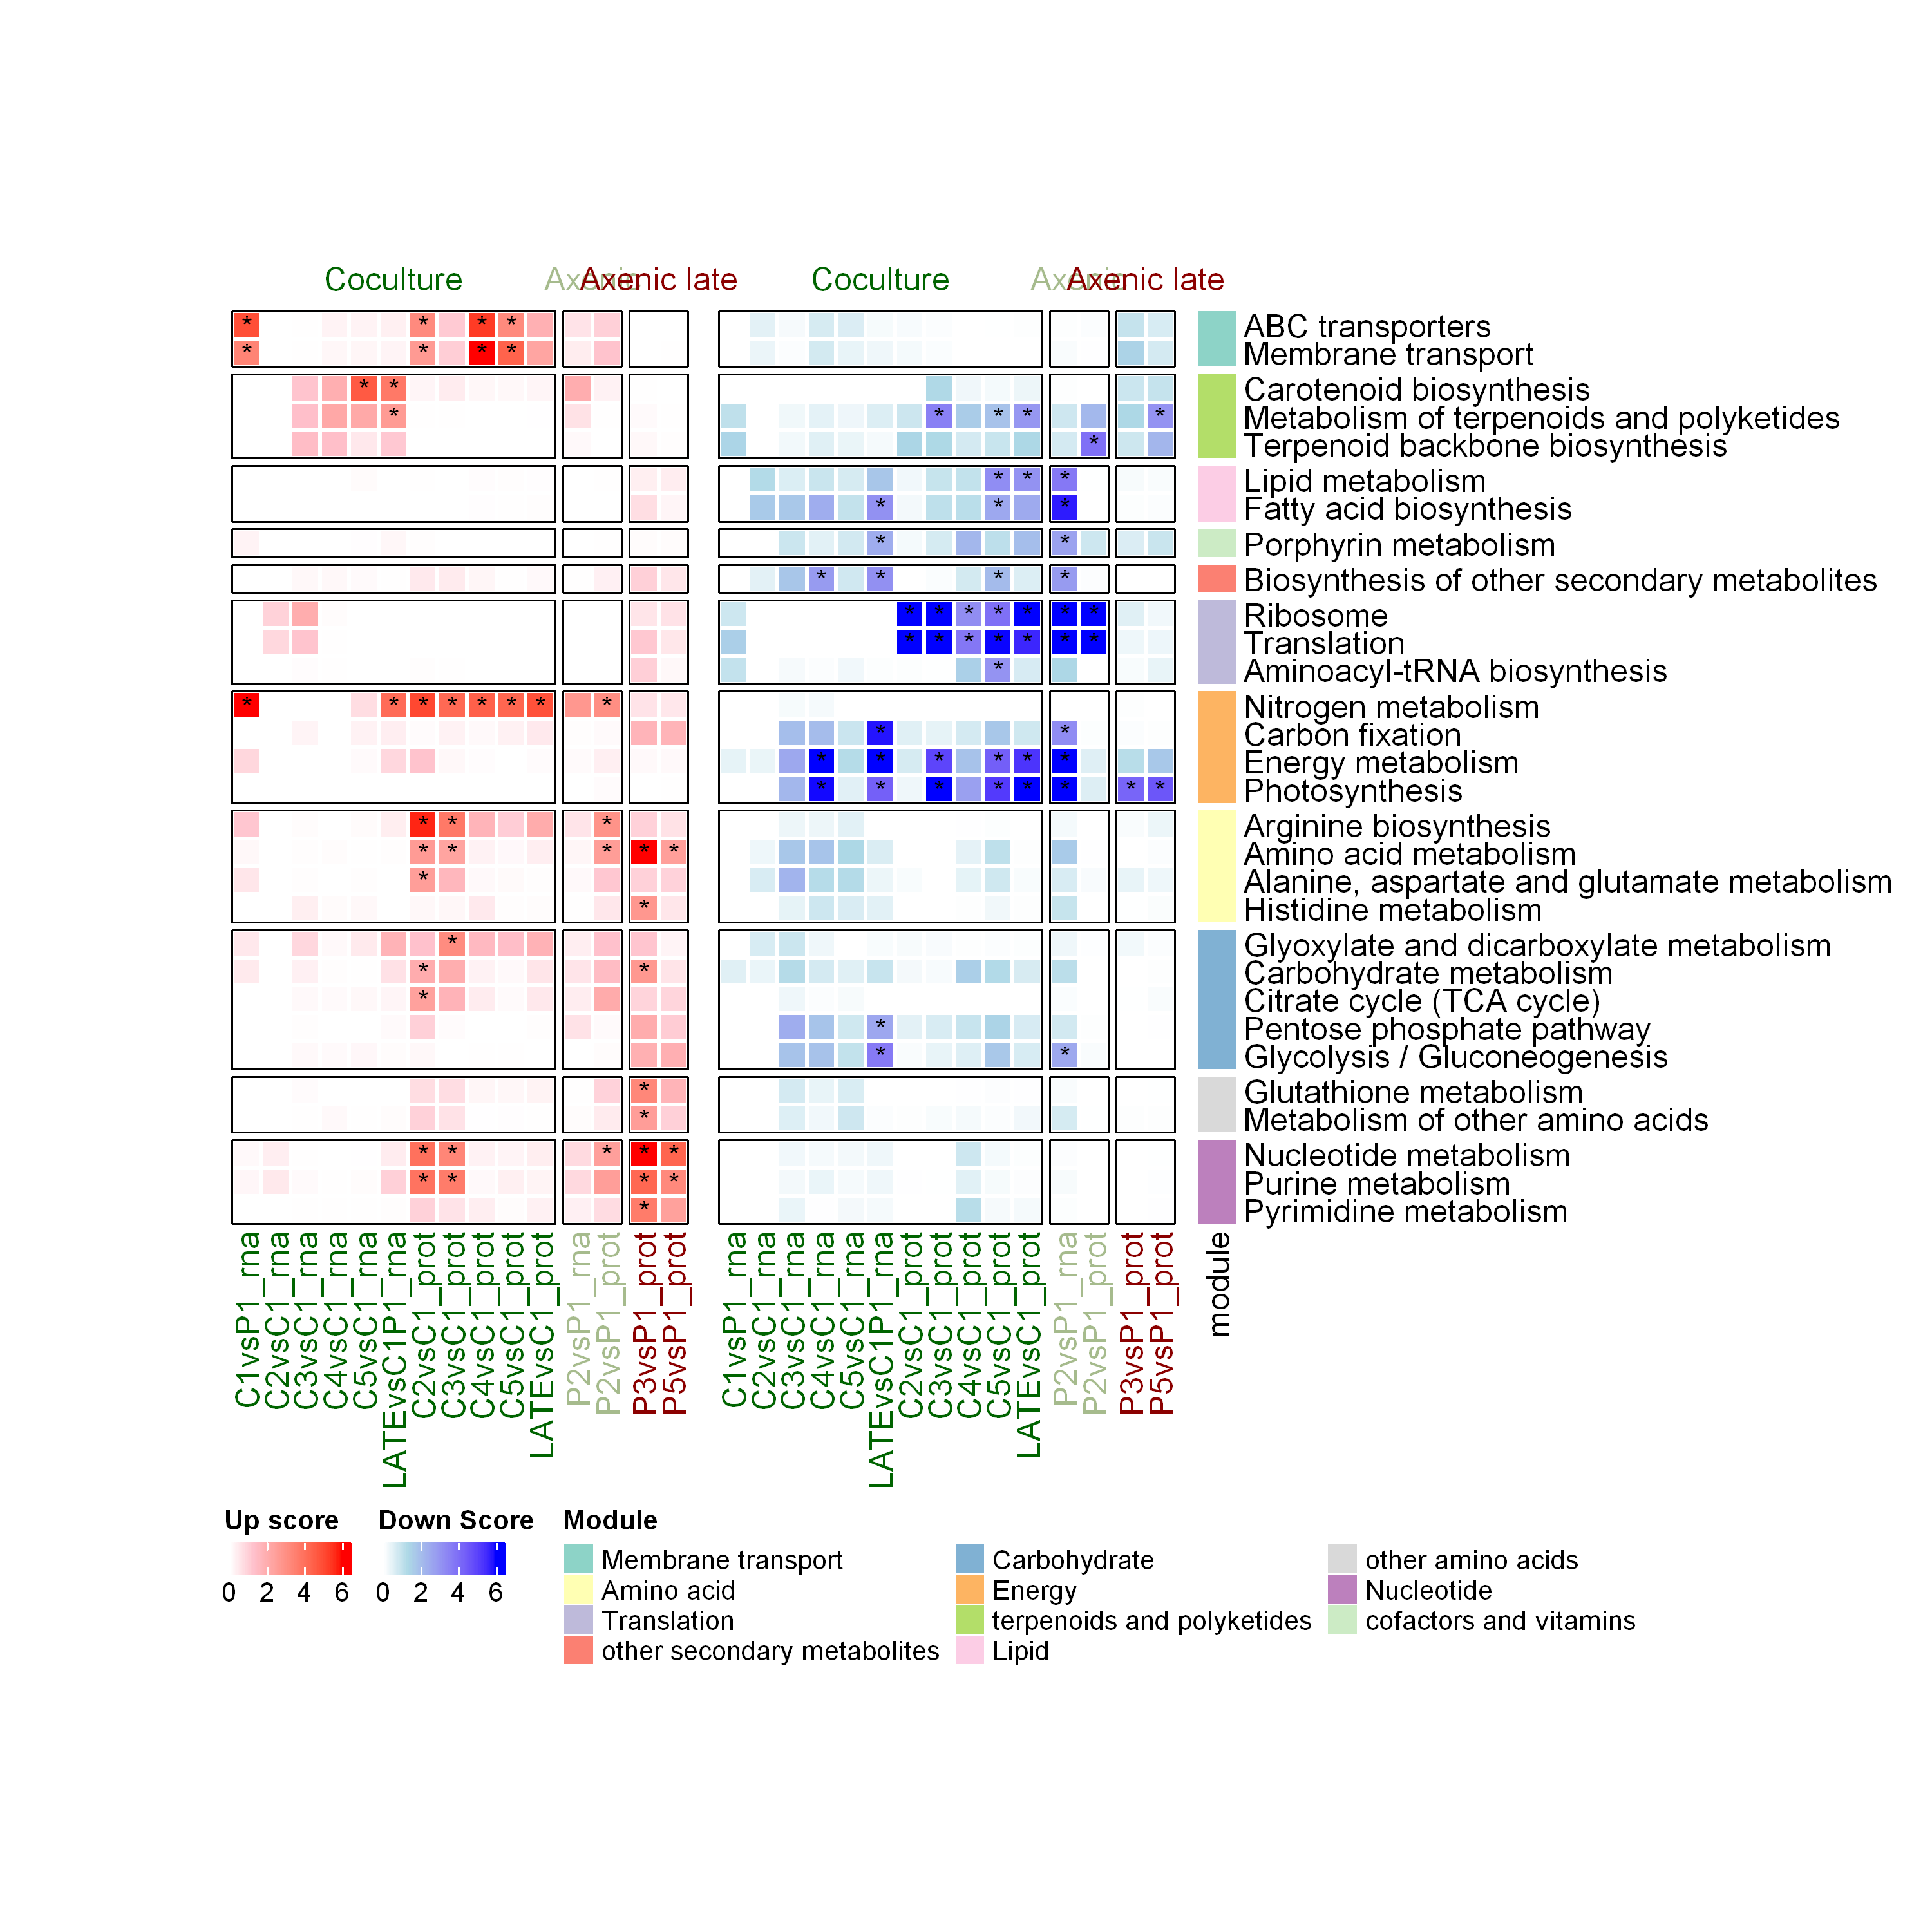

In [23]:
toppaths = goseq_res %>% 
    filter(#enrich=='path', 
           padj < 0.05) %>% 
    distinct(pathway)

# row_ha = rowAnnotation(foo2 = runif(10), ))

module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
    distinct(pathway, module) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') 

# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    row_split = module_mat$module,
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(12, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    relocate(rownames(goseq_meta)) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Down Score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(15, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

ann_mat = Heatmap(
    as.matrix(module_mat), 
    name='Module',
    width=unit(0.5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal", ncol=3),
    col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = unique(module_mat$module)),
    row_title=FALSE,
)

ht_list = up_mat + down_mat + ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

# Heatmap per Module

In [24]:
genome = 'MED4'

In [25]:
modules_de = goseq_res %>% 
    filter(padj < 0.05) %>% 
    count(module)



In [26]:
deg = df_all %>% filter(padj < 0.05) %>% distinct(gene_id)
hpath_df %>% 
    filter(gene_id %in% deg$gene_id, module %in% modules_de$module) %>% 
    distinct(gene_id, module) %>%
    count(module) %>% arrange(n)



module                      n  
1  Lipid                        25
2  other secondary metabolites  25
3  terpenoids and polyketides   25
4  other amino acids            30
5  Membrane transport           42
6  Nucleotide                   55
7  Translation                  78
8  Carbohydrate                 88
9  Amino acid                  108
10 Energy                      116
11 cofactors and vitamins      129

## cofactors and vitamins 

In [27]:
module_name = 'cofactors and vitamins'
module_title = paste0(genome, ' ',module_name)

In [28]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [29]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


In [30]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [31]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)

gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>%
#    select(pathwaylist$pathway) %>% 
as.matrix()
head(gene_meta)

gene         Thiamine metabolism Porphyrin metabolism
TX50_RS00110 rsgA         Yes                 No                  
TX50_RS00195 cbiD         No                  Yes                 
TX50_RS00275 (E1.1.1.65)  No                  No                  
TX50_RS00415 (LYS5, acpT) No                  No                  
TX50_RS00425 (coaX)       No                  No                  
TX50_RS00435 (NDC1, ndbB) No                  No                  
             Vitamin B6 metabolism Pantothenate and CoA biosynthesis
TX50_RS00110 No                    No                               
TX50_RS00195 No                    No                               
TX50_RS00275 Yes                   No                               
TX50_RS00415 No                    Yes                              
TX50_RS00425 No                    Yes                              
TX50_RS00435 No                    No                               
             Ubiquinone and other terpenoid-quinone biosynthesis
TX50_RS00110 No                                                 
TX50_RS00195 No                                                 
TX50_RS00275 No                                                 
TX50_RS00415 No                                                 
TX50_RS00425 No                                                 
TX50_RS00435 Yes                                                
             Nicotinate and nicotinamide metabolism Folate biosynthesis
TX50_RS00110 No                                     No                 
TX50_RS00195 No                                     No                 
TX50_RS00275 No                                     No                 
TX50_RS00415 No                                     No                 
TX50_RS00425 No                                     No                 
TX50_RS00435 No                                     No                 
             One carbon pool by folate Biotin metabolism Riboflavin metabolism
TX50_RS00110 No                        No                No                   
TX50_RS00195 No                        No                No                   
TX50_RS00275 No                        No                No                   
TX50_RS00415 No                        No                No                   
TX50_RS00425 No                        No                No                   
TX50_RS00435 No                        No                No                   
             Lipoic acid metabolism Retinol metabolism
TX50_RS00110 No                     No                
TX50_RS00195 No                     No                
TX50_RS00275 No                     No                
TX50_RS00415 No                     No                
TX50_RS00425 No                     No                
TX50_RS00435 No                     No

In [32]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


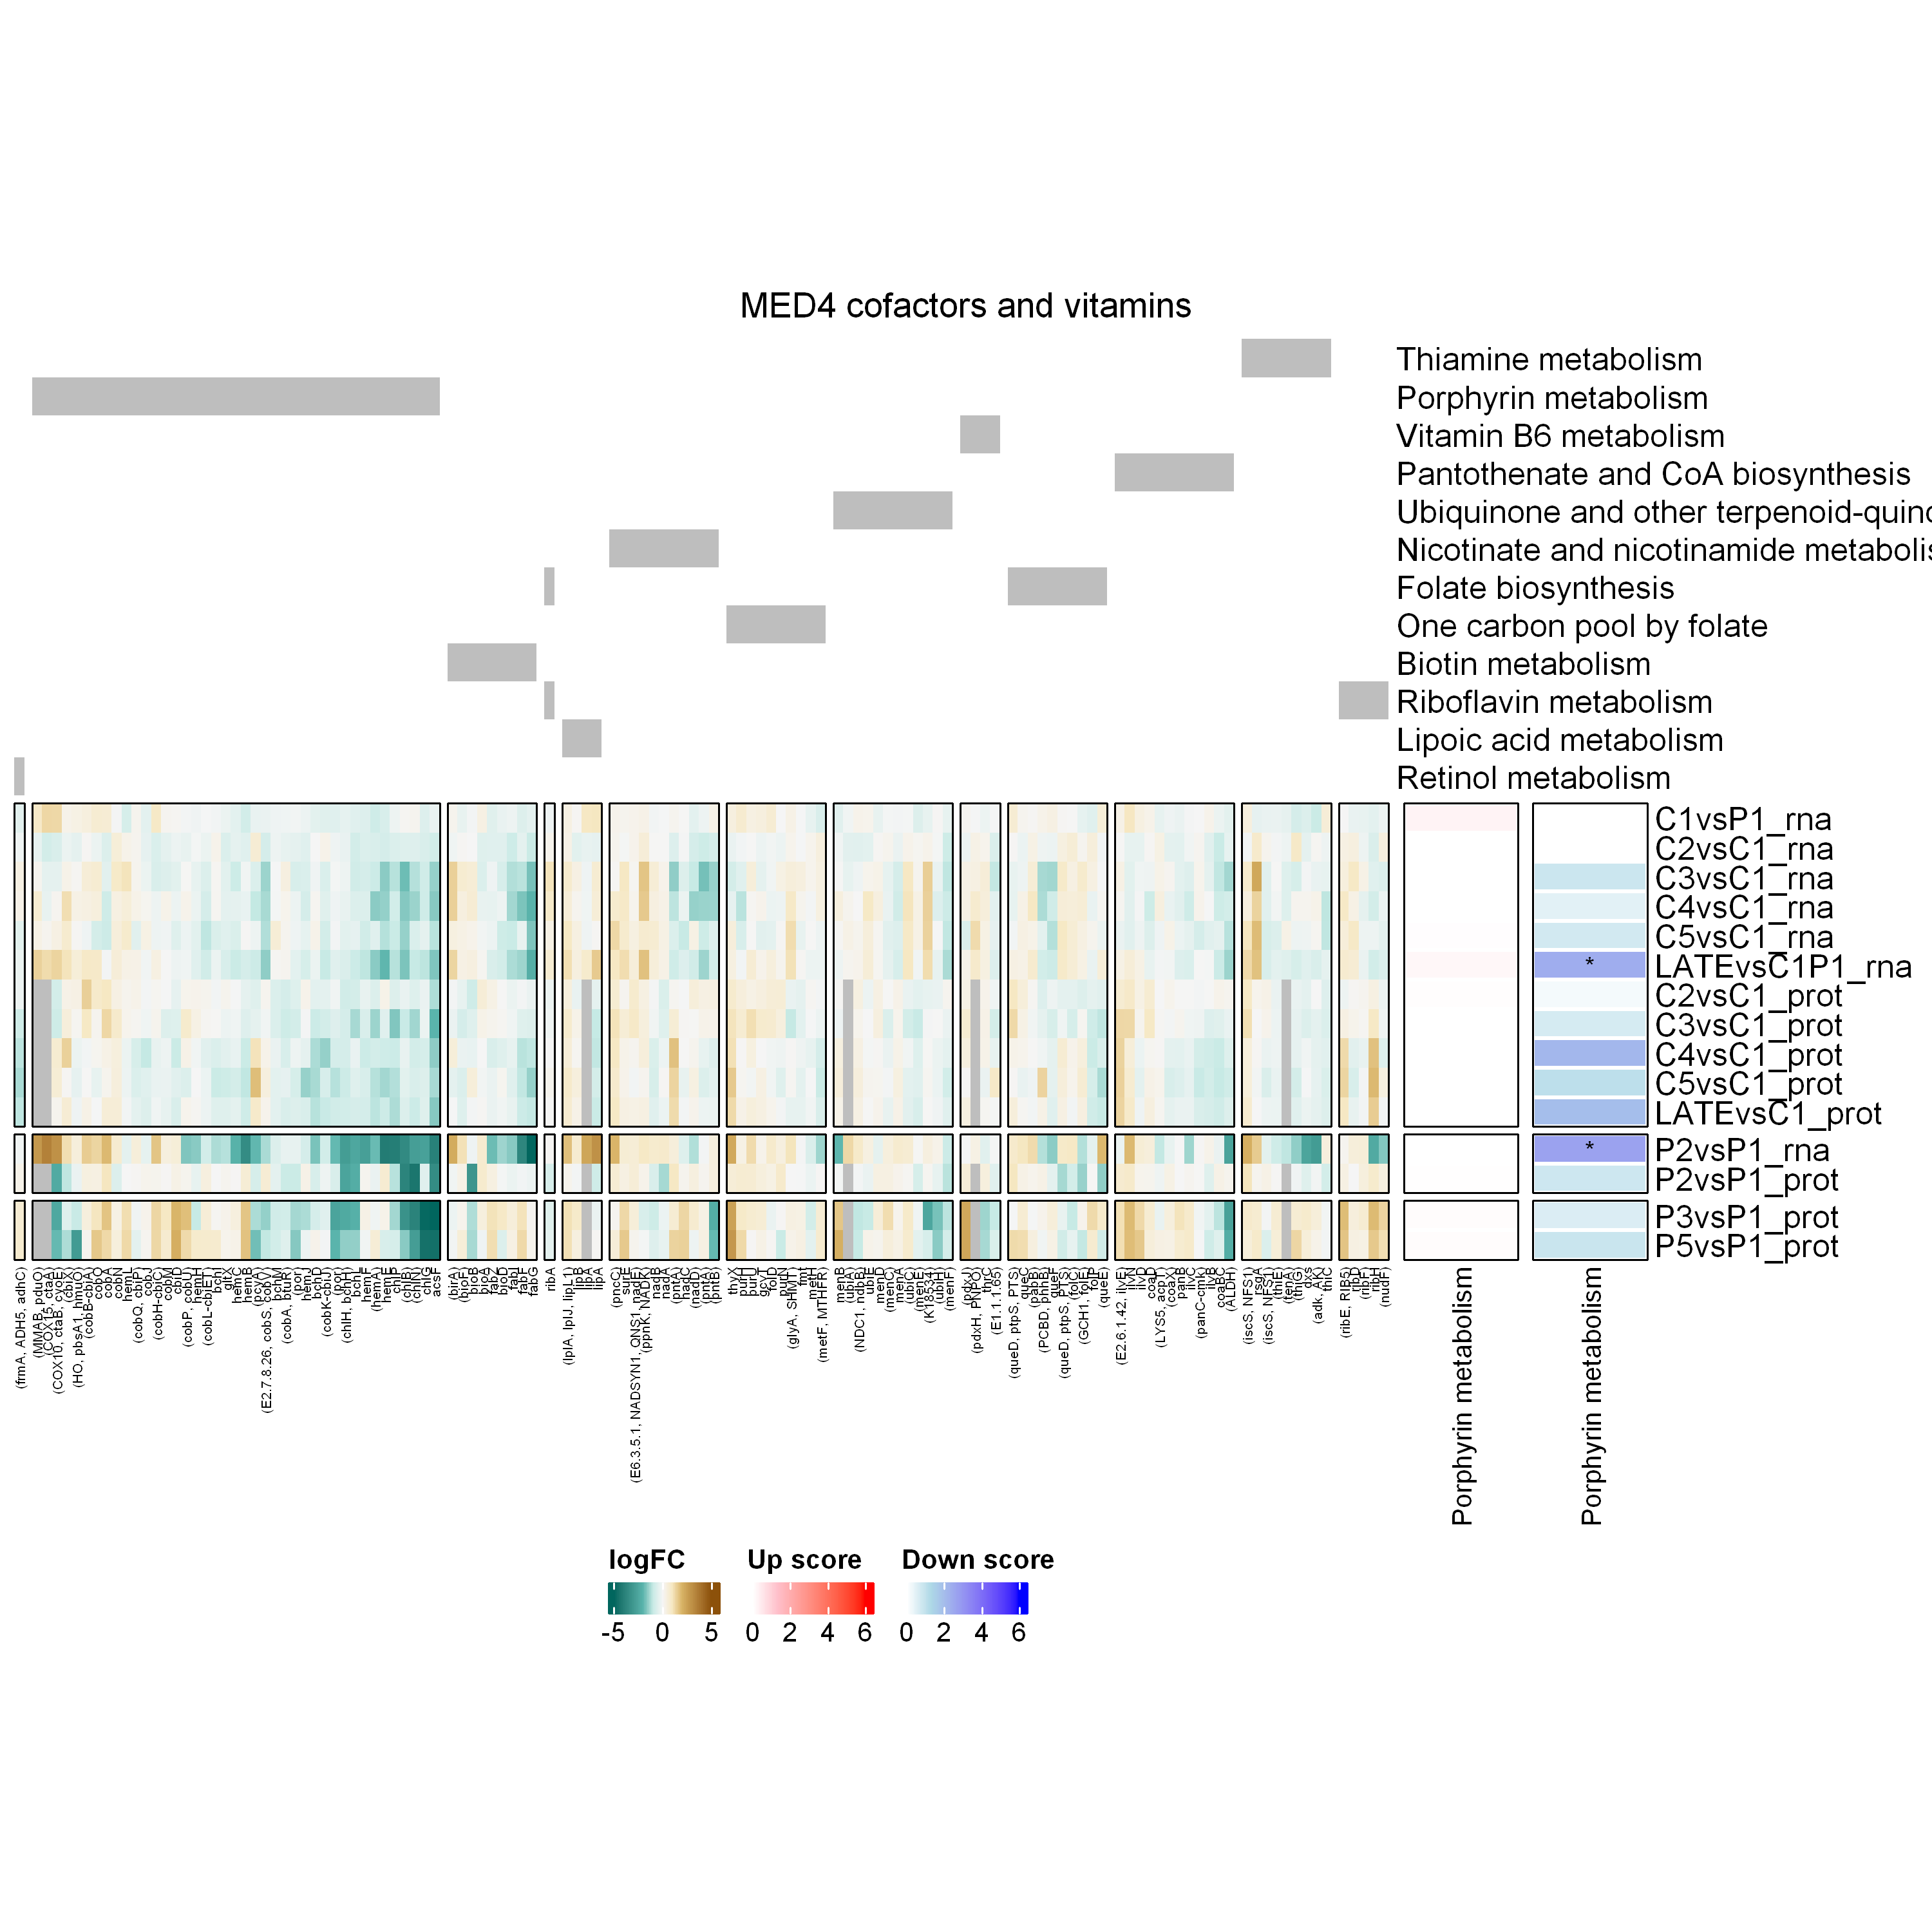

In [33]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
#     cell_fun = function(j, i, x, y, width, height, fill) {
#         grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
#     },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Energy 

In [34]:
module_name = 'Energy'
module_title = paste0(genome, ' ',module_name)

In [35]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [36]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


In [37]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [38]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)

gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>%
    select(pathwaylist$pathway) %>% as.matrix()
head(gene_meta)

gene   Carbon fixation Carbon fixation pathways in prokaryotes
TX50_RS00130 gap    Yes             No                                     
TX50_RS00150 accB   No              Yes                                    
TX50_RS00320 accC   No              Yes                                    
TX50_RS00430 (cysH) No              No                                     
TX50_RS00645 cysK   No              No                                     
TX50_RS00760 (ndhM) No              No                                     
             Sulfur metabolism Oxidative phosphorylation Methane metabolism
TX50_RS00130 No                No                        No                
TX50_RS00150 No                No                        No                
TX50_RS00320 No                No                        No                
TX50_RS00430 Yes               No                        No                
TX50_RS00645 Yes               No                        No                
TX50_RS00760 No                Yes                       No                
             Photosynthesis Photosynthesis - antenna proteins
TX50_RS00130 No             No                               
TX50_RS00150 No             No                               
TX50_RS00320 No             No                               
TX50_RS00430 No             No                               
TX50_RS00645 No             No                               
TX50_RS00760 No             No                               
             Nitrogen metabolism
TX50_RS00130 No                 
TX50_RS00150 No                 
TX50_RS00320 No                 
TX50_RS00430 No                 
TX50_RS00645 No                 
TX50_RS00760 No

In [39]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


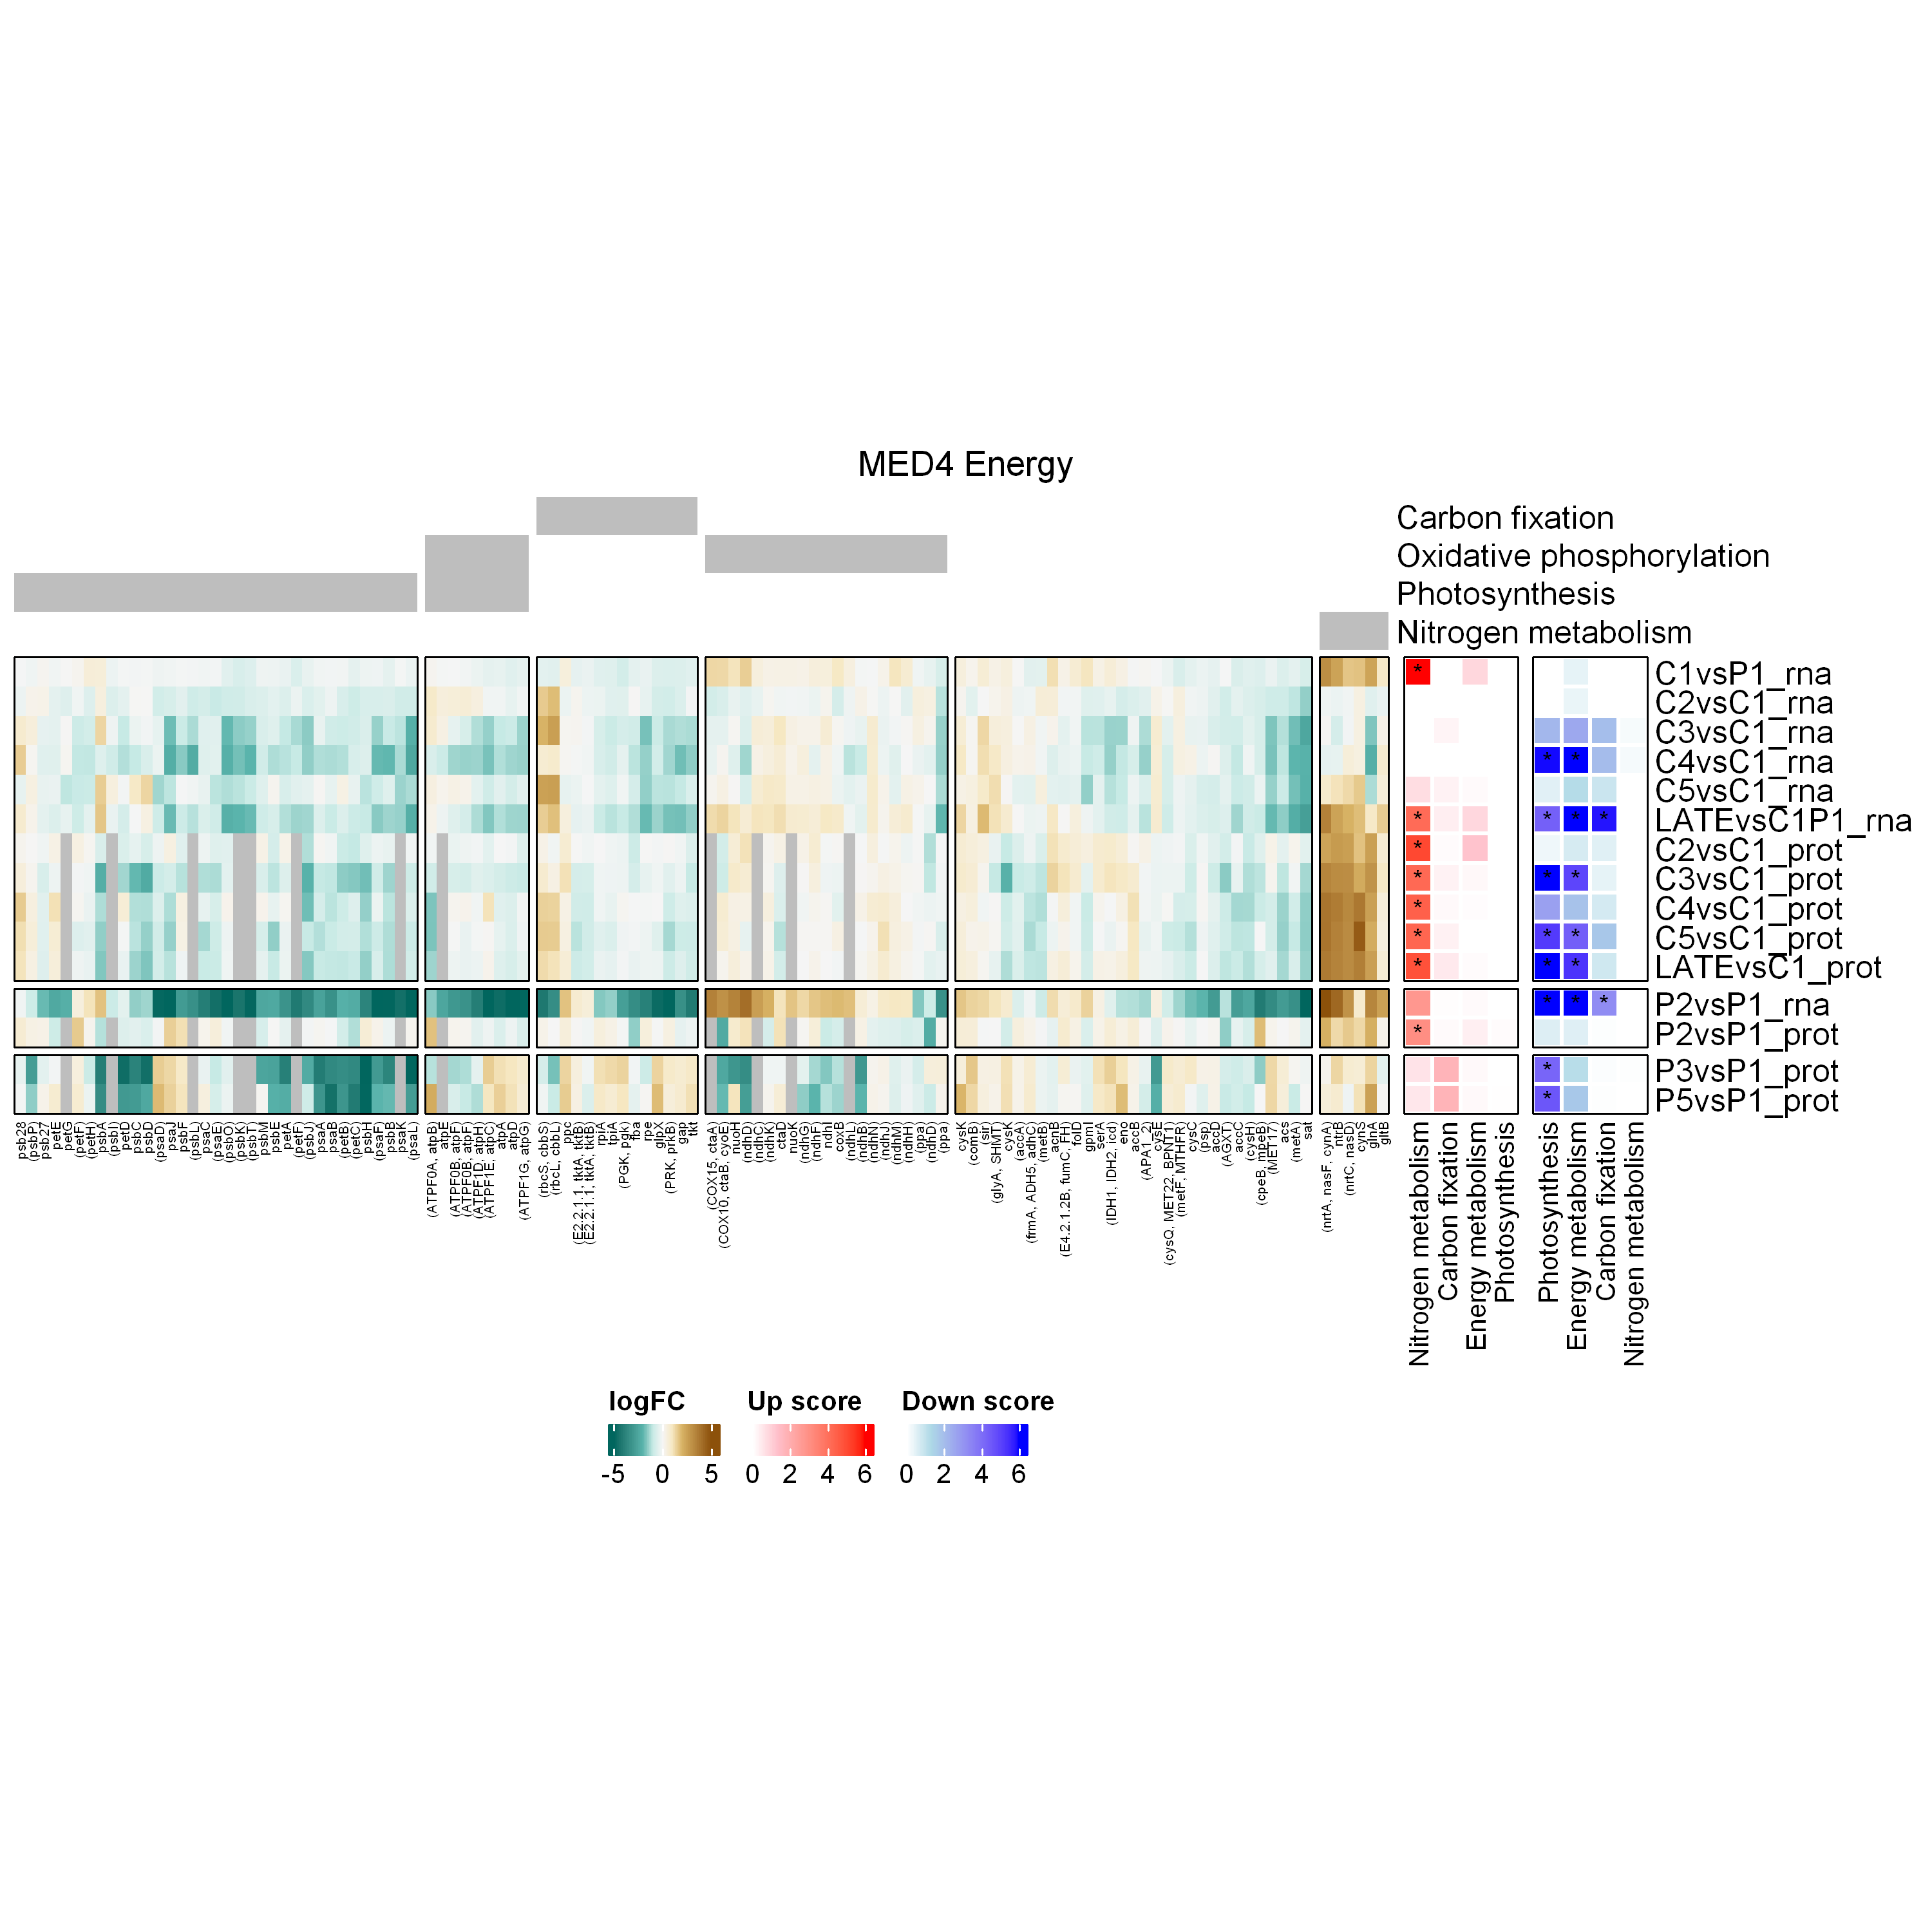

In [40]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
#     cell_fun = function(j, i, x, y, width, height, fill) {
#         grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
#     },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Carbohydrate 

In [41]:
module_name = 'Carbohydrate'
module_title = paste0(genome, ' ',module_name)

In [42]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [43]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


In [44]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [45]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)

gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>%
    select(pathwaylist$pathway) %>% as.matrix()
head(gene_meta)

gene                   
TX50_RS00120 murB                   
TX50_RS00130 gap                    
TX50_RS00150 accB                   
TX50_RS00320 accC                   
TX50_RS00405 (pgm)                  
TX50_RS00510 (E3.1.3.25, IMPA, suhB)
             Amino sugar and nucleotide sugar metabolism
TX50_RS00120 Yes                                        
TX50_RS00130 No                                         
TX50_RS00150 No                                         
TX50_RS00320 No                                         
TX50_RS00405 Yes                                        
TX50_RS00510 No                                         
             Glycolysis / Gluconeogenesis Pyruvate metabolism
TX50_RS00120 No                           No                 
TX50_RS00130 Yes                          No                 
TX50_RS00150 No                           Yes                
TX50_RS00320 No                           Yes                
TX50_RS00405 Yes                          No                 
TX50_RS00510 No                           No                 
             Propanoate metabolism Pentose phosphate pathway
TX50_RS00120 No                    No                       
TX50_RS00130 No                    No                       
TX50_RS00150 Yes                   No                       
TX50_RS00320 Yes                   No                       
TX50_RS00405 No                    Yes                      
TX50_RS00510 No                    No                       
             Galactose metabolism Starch and sucrose metabolism
TX50_RS00120 No                   No                           
TX50_RS00130 No                   No                           
TX50_RS00150 No                   No                           
TX50_RS00320 No                   No                           
TX50_RS00405 Yes                  Yes                          
TX50_RS00510 No                   No                           
             Inositol phosphate metabolism Fructose and mannose metabolism
TX50_RS00120 No                            No                             
TX50_RS00130 No                            No                             
TX50_RS00150 No                            No                             
TX50_RS00320 No                            No                             
TX50_RS00405 No                            No                             
TX50_RS00510 Yes                           No                             
             Citrate cycle (TCA cycle) Glyoxylate and dicarboxylate metabolism
TX50_RS00120 No                        No                                     
TX50_RS00130 No                        No                                     
TX50_RS00150 No                        No                                     
TX50_RS00320 No                        No                                     
TX50_RS00405 No                        No                                     
TX50_RS00510 No                        No                                     
             C5-Branched dibasic acid metabolism
TX50_RS00120 No                                 
TX50_RS00130 No                                 
TX50_RS00150 No                                 
TX50_RS00320 No                                 
TX50_RS00405 No                                 
TX50_RS00510 No                                 
             Pentose and glucuronate interconversions
TX50_RS00120 No                                      
TX50_RS00130 No                                      
TX50_RS00150 No                                      
TX50_RS00320 No                                      
TX50_RS00405 No                                      
TX50_RS00510 No                                      
             Ascorbate and aldarate metabolism Butanoate metabolism
TX50_RS00120 No                                No                  
TX50_RS00130 No                                No                  
TX50_RS00150 No                            

In [46]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


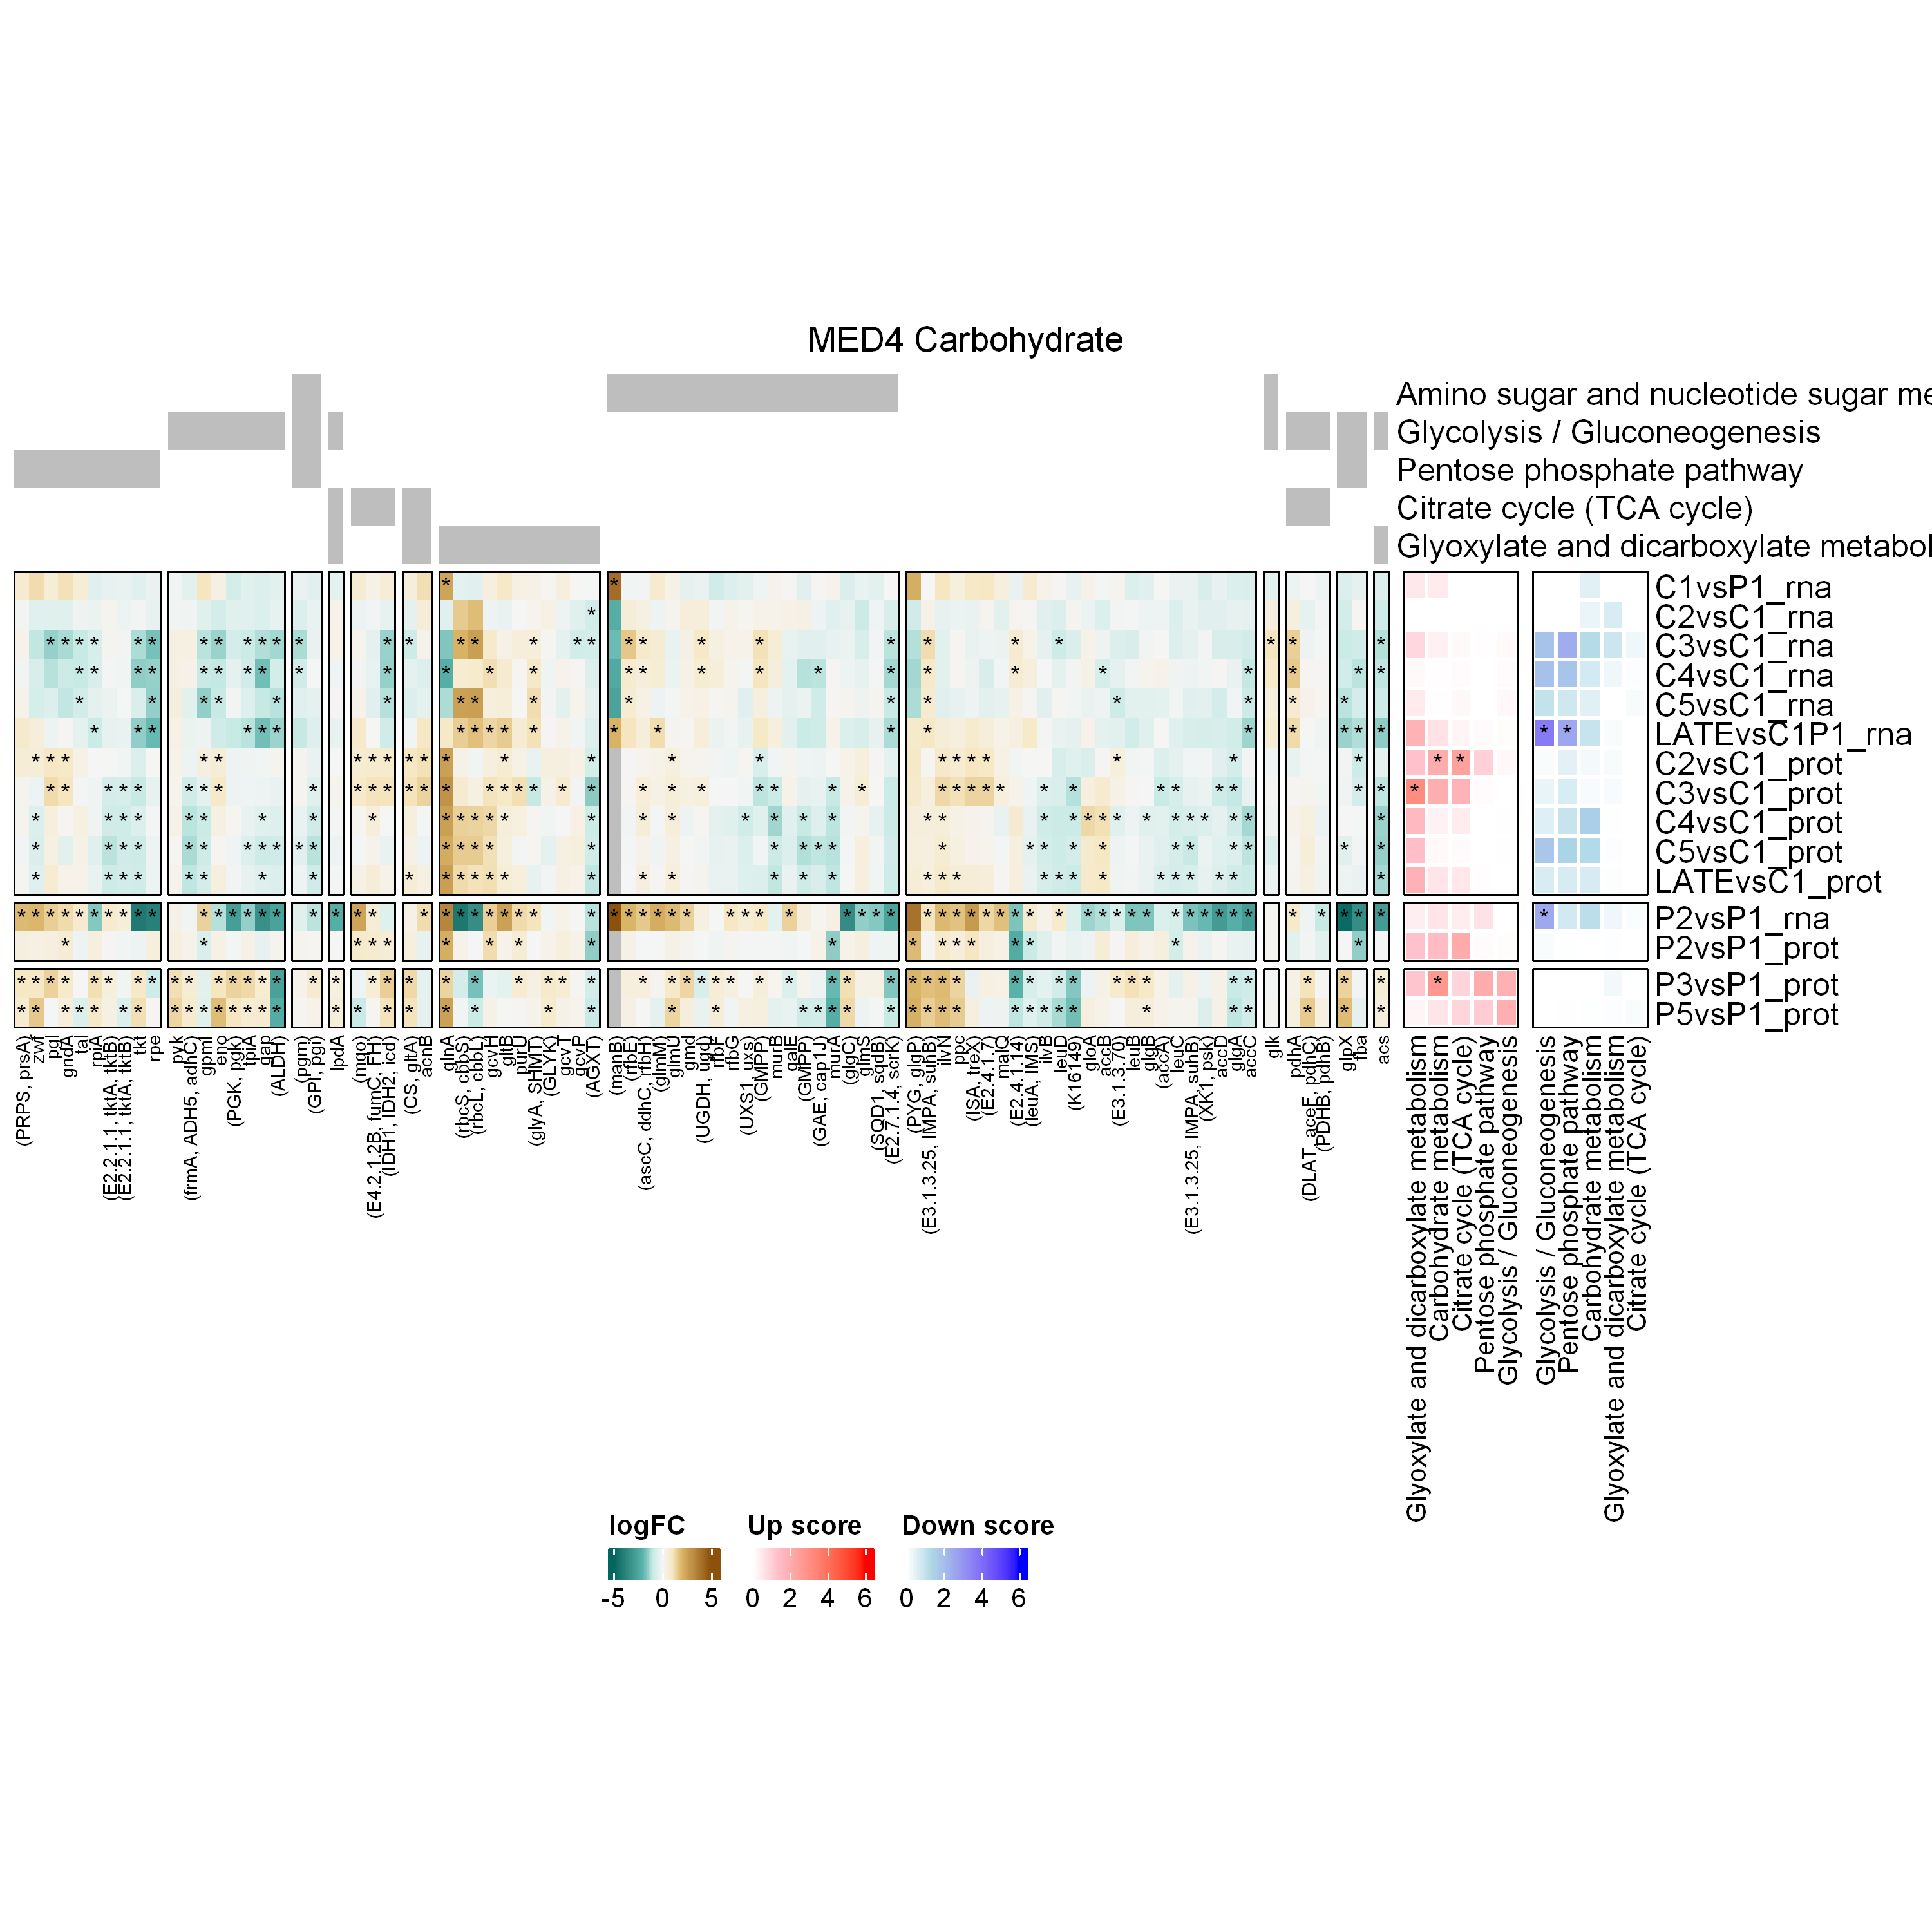

In [47]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 7),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Translation 

In [48]:
module_name = 'Translation'
module_title = paste0(genome, ' ',module_name)

In [49]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [50]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [51]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

gene Aminoacyl-tRNA biosynthesis Ribosome
TX50_RS00235 alaS Yes                         No      
TX50_RS00255 gatB Yes                         No      
TX50_RS00970 argS Yes                         No      
TX50_RS01040 rplL No                          Yes     
TX50_RS01045 rplJ No                          Yes     
TX50_RS01050 rplA No                          Yes     
             Ribosome biogenesis in eukaryotes
TX50_RS00235 No                               
TX50_RS00255 No                               
TX50_RS00970 No                               
TX50_RS01040 No                               
TX50_RS01045 No                               
TX50_RS01050 No

In [52]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


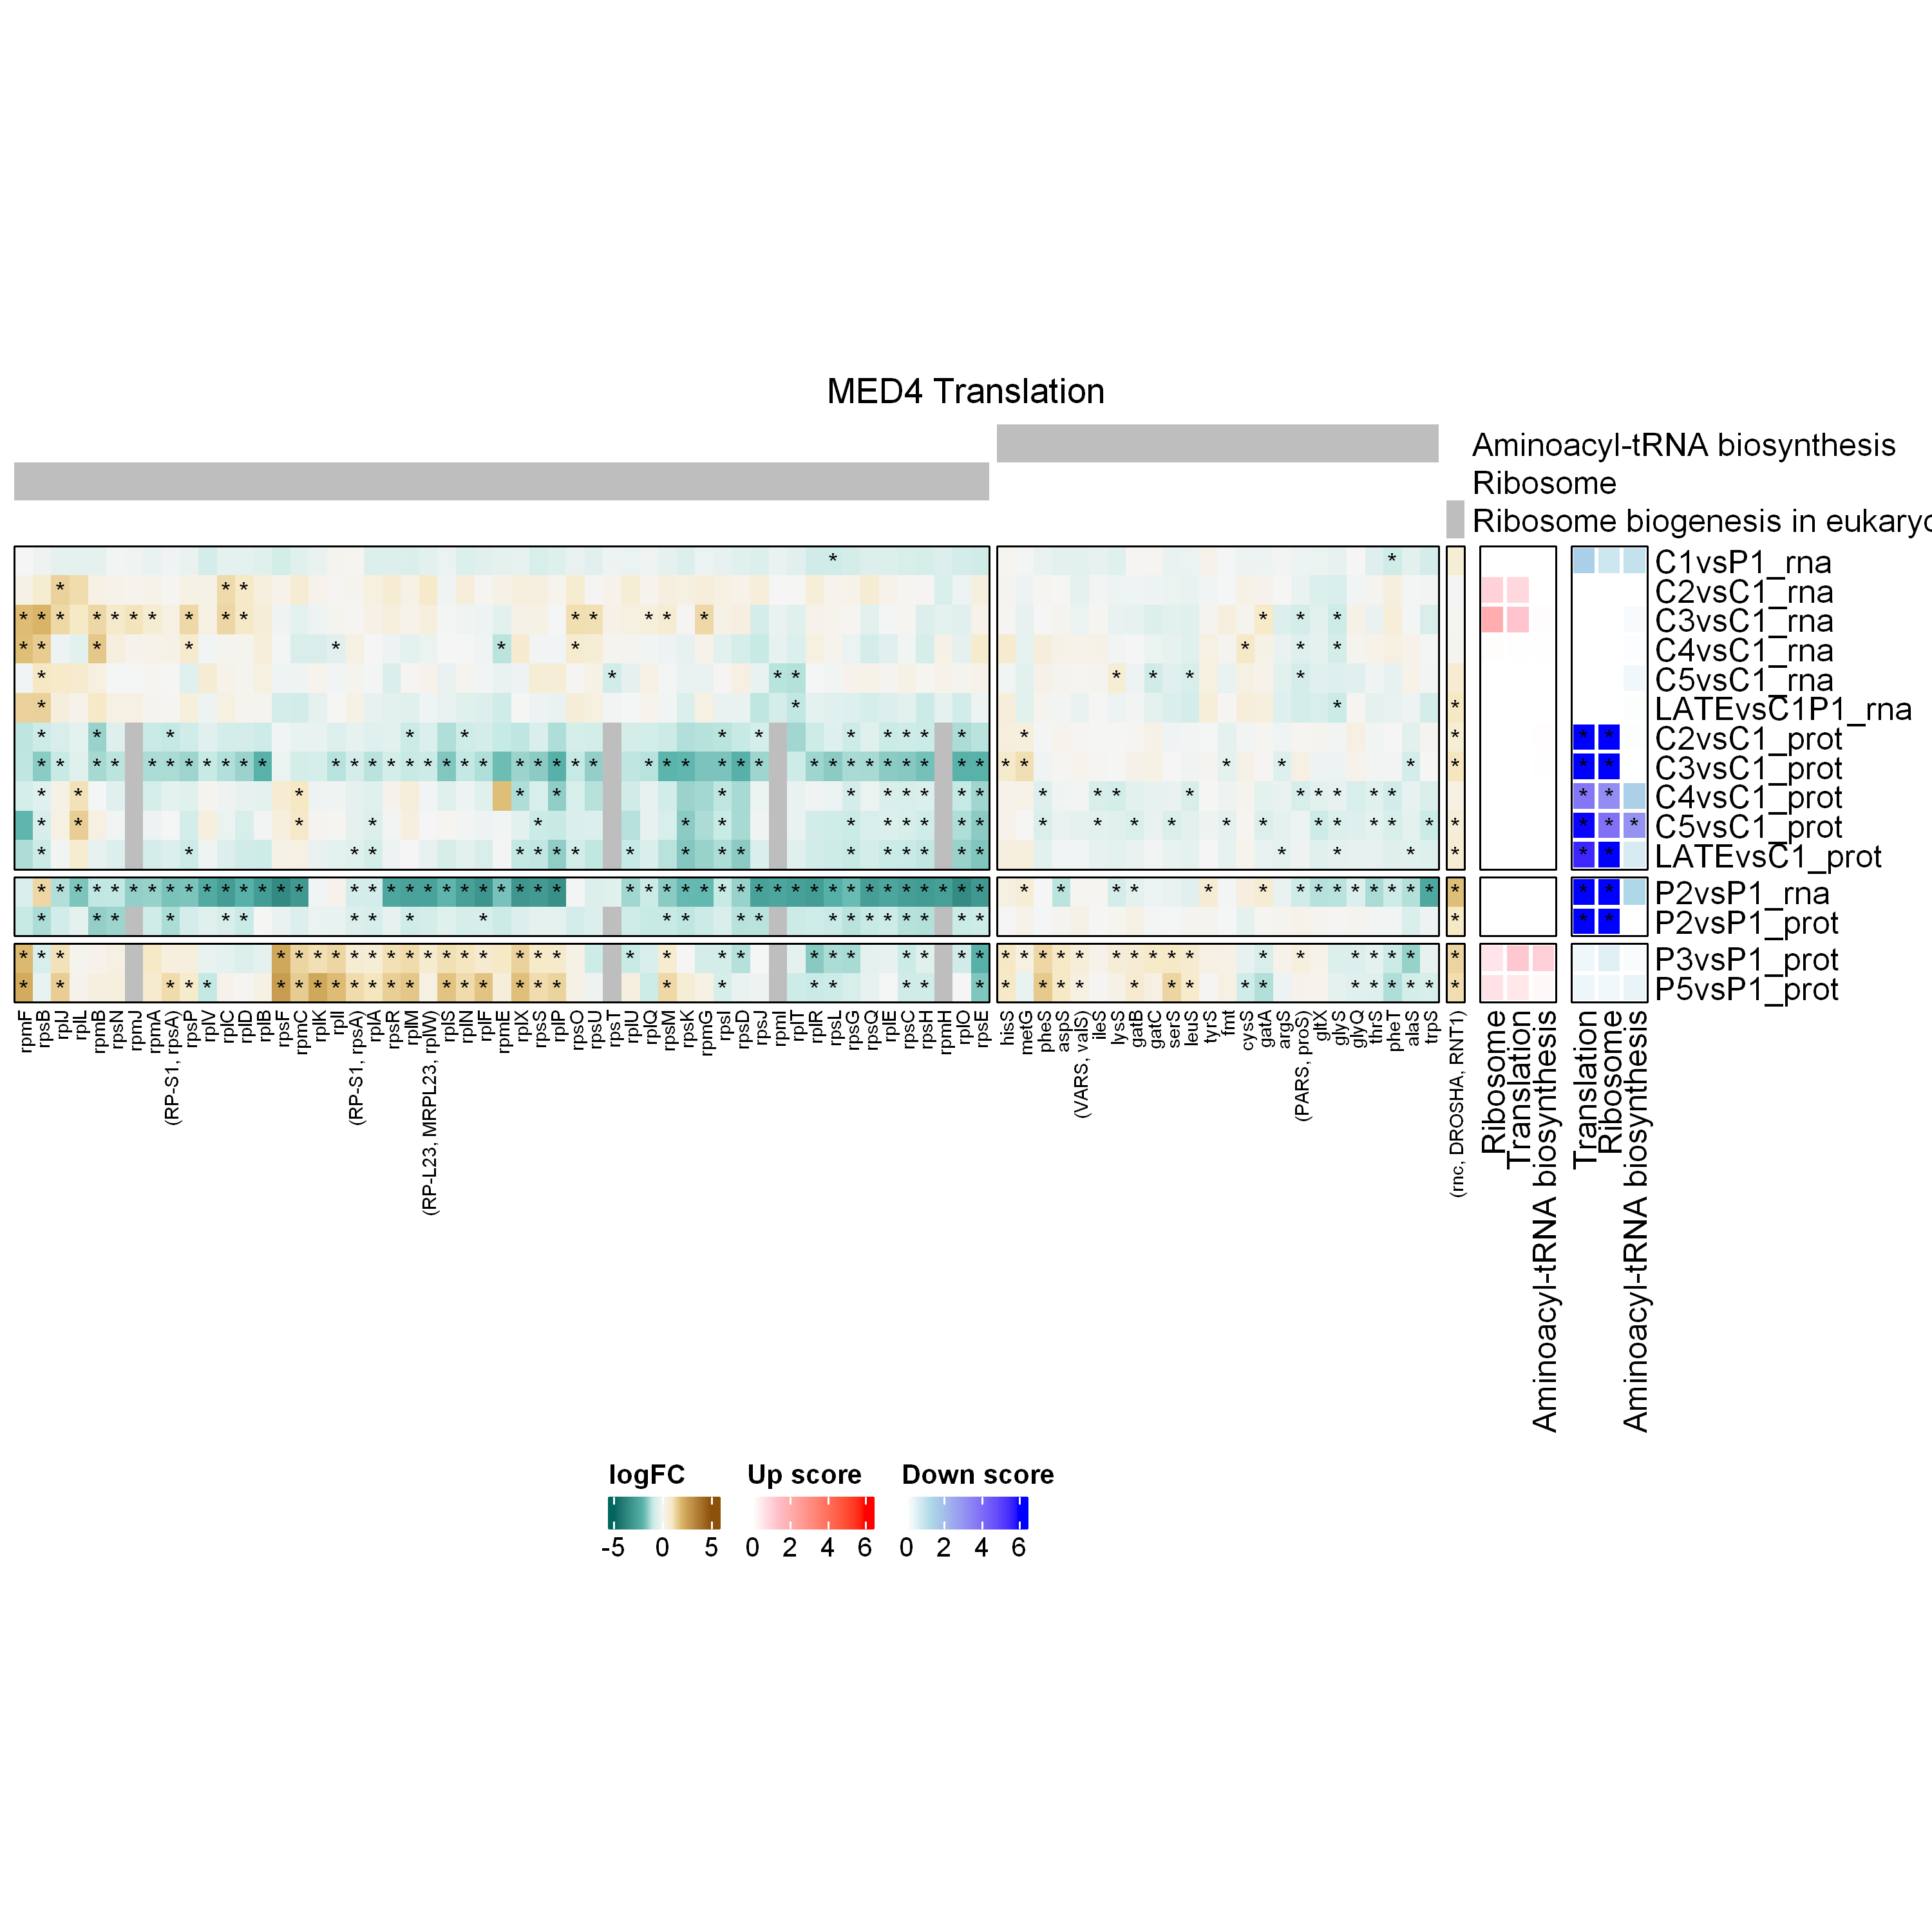

In [53]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 7),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Nucleotide 

In [54]:
module_name = 'Nucleotide'
module_title = paste0(genome, ' ',module_name)

In [55]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [56]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [57]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

gene  Purine metabolism Pyrimidine metabolism
TX50_RS00030 purL  Yes               No                   
TX50_RS00035 purF  Yes               No                   
TX50_RS00200 guaA  Yes               No                   
TX50_RS00245 ndk   Yes               Yes                  
TX50_RS00405 (pgm) Yes               No                   
TX50_RS00685 tmk   No                Yes

In [58]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


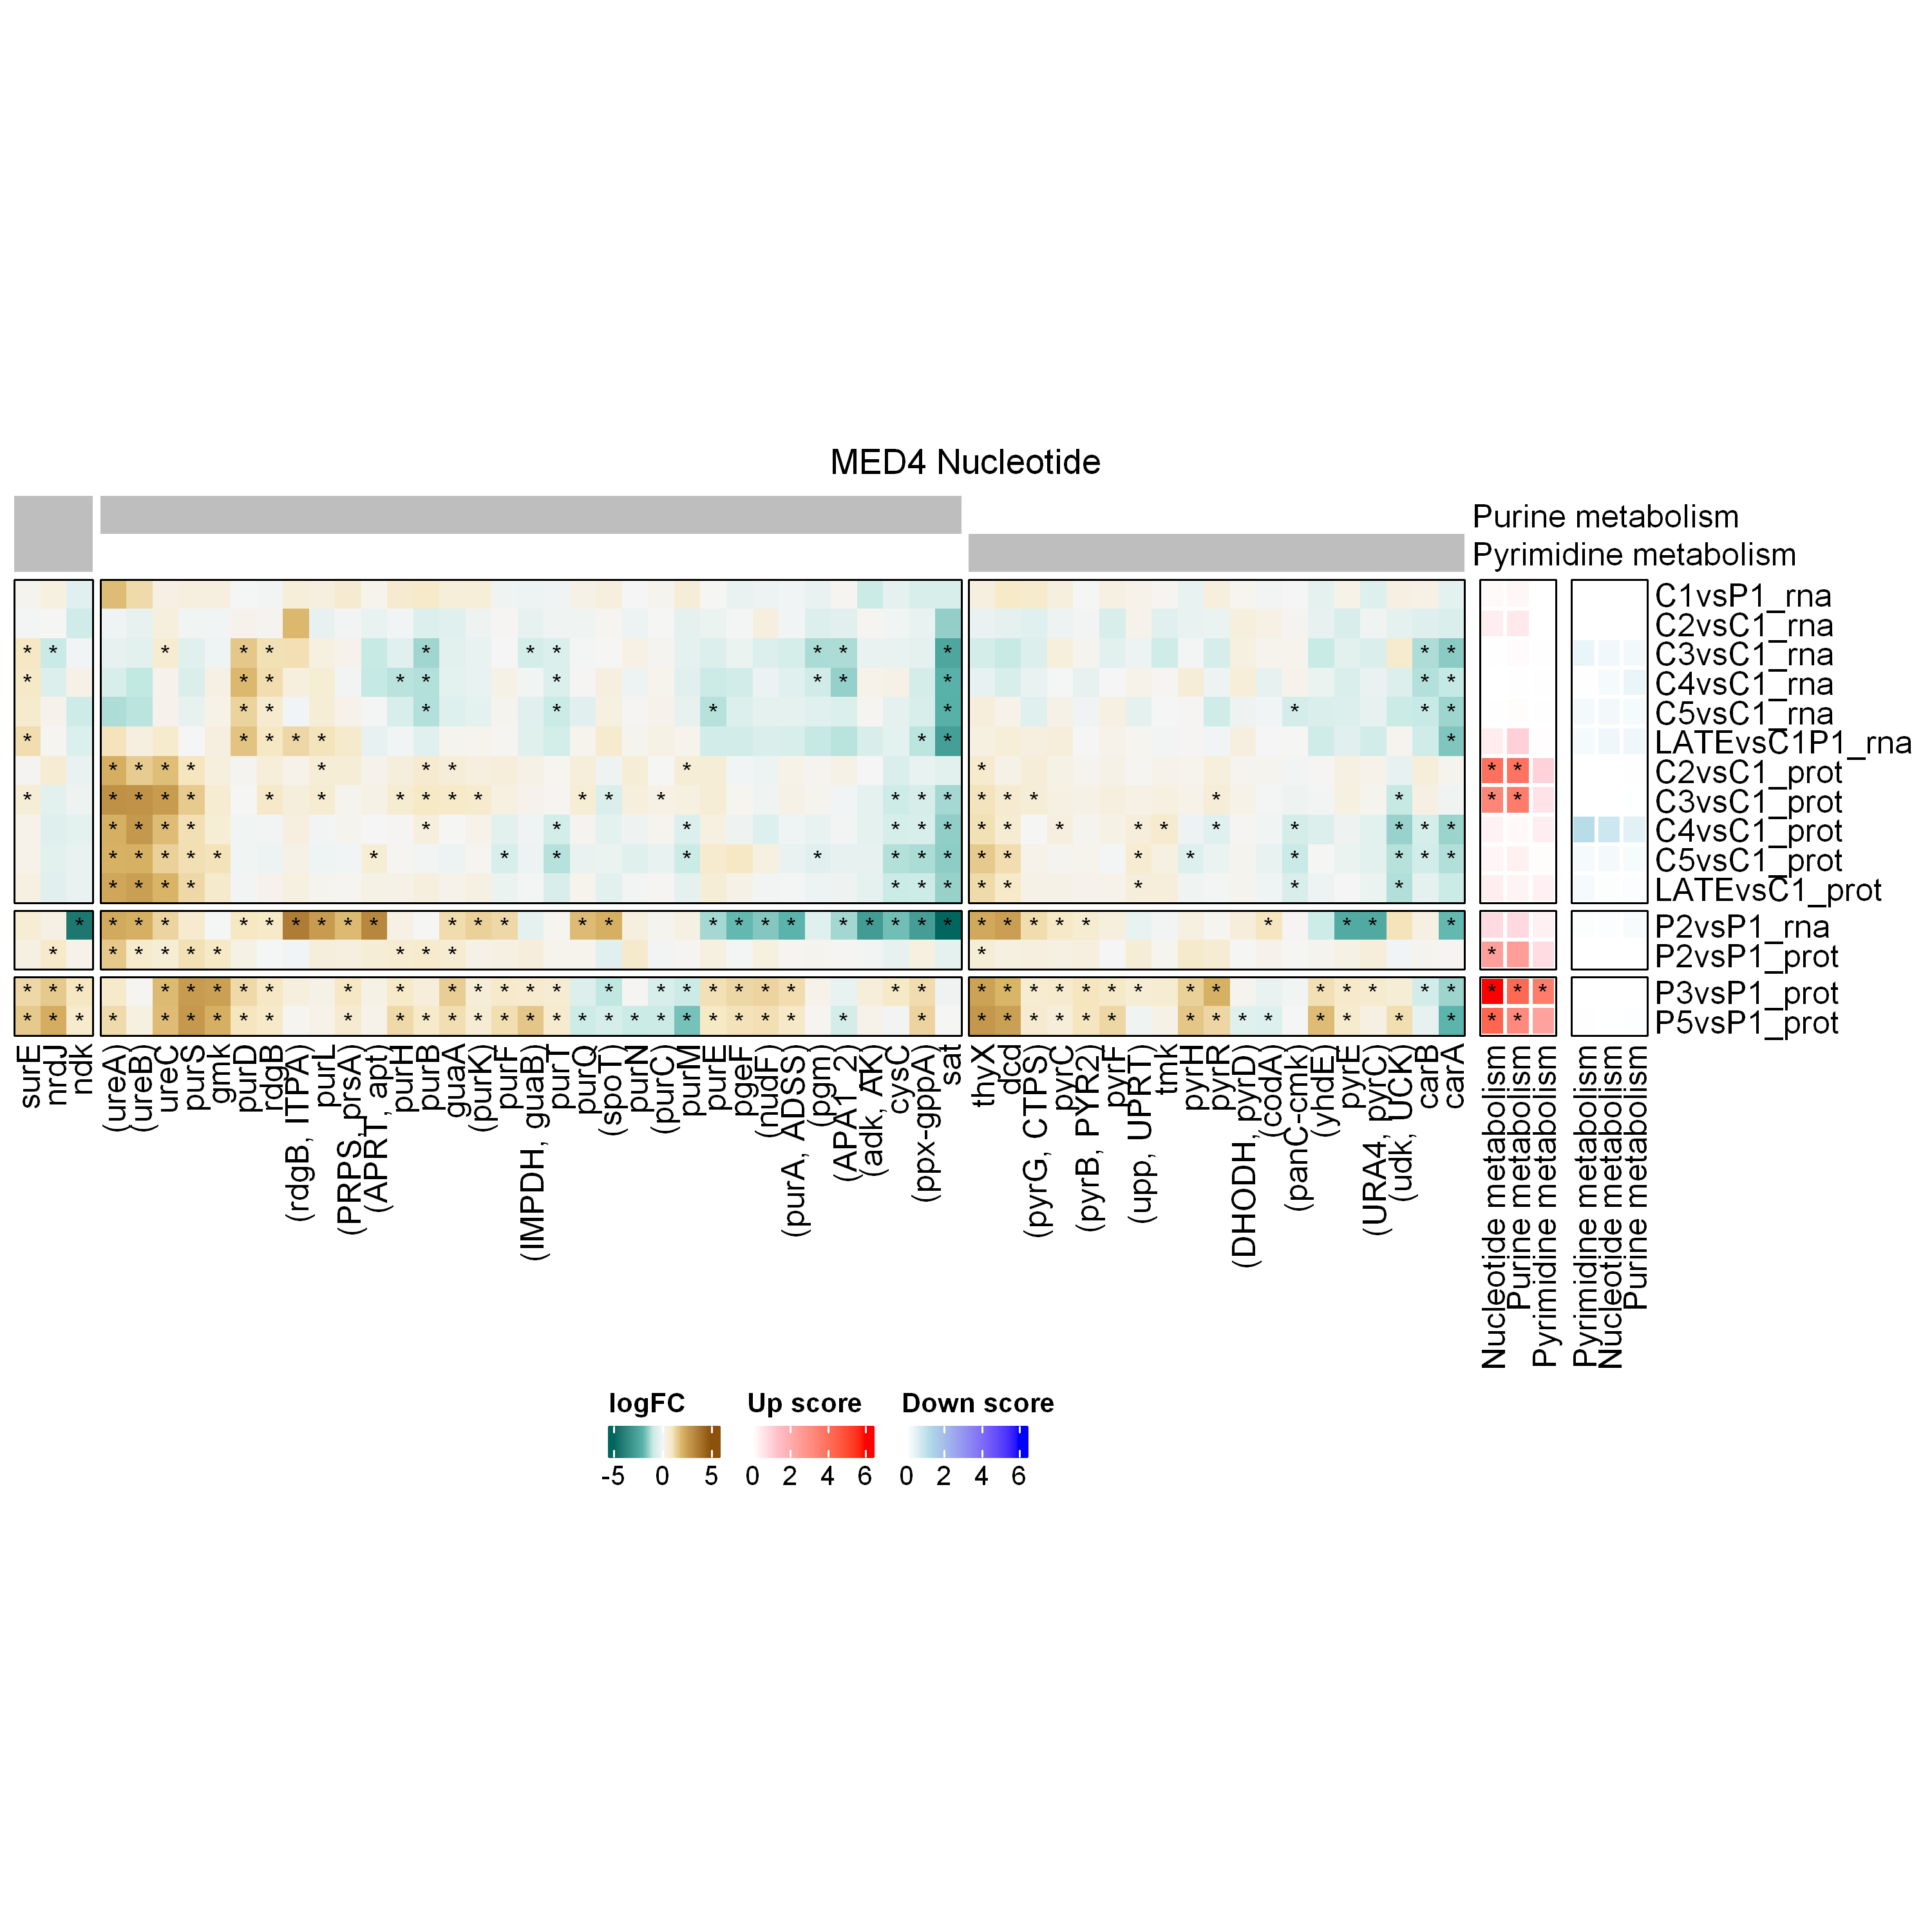

In [59]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## other amino acids 

In [60]:
module_name = 'other amino acids'
module_title = paste0(genome, ' ',module_name)

In [61]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [62]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [63]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

gene         Selenocompound metabolism Glutathione metabolism
TX50_RS00370 (sufS)       Yes                       No                    
TX50_RS00585 (GST, gst)   No                        Yes                   
TX50_RS00925 gshB         No                        Yes                   
TX50_RS01090 (trxB, TRR)  Yes                       No                    
TX50_RS01170 sat          Yes                       No                    
TX50_RS01335 (glyA, SHMT) No                        No                    
             Cyanoamino acid metabolism beta-Alanine metabolism
TX50_RS00370 No                         No                     
TX50_RS00585 No                         No                     
TX50_RS00925 No                         No                     
TX50_RS01090 No                         No                     
TX50_RS01170 No                         No                     
TX50_RS01335 Yes                        No                     
             D-Amino acid metabolism
TX50_RS00370 No                     
TX50_RS00585 No                     
TX50_RS00925 No                     
TX50_RS01090 No                     
TX50_RS01170 No                     
TX50_RS01335 No

In [64]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


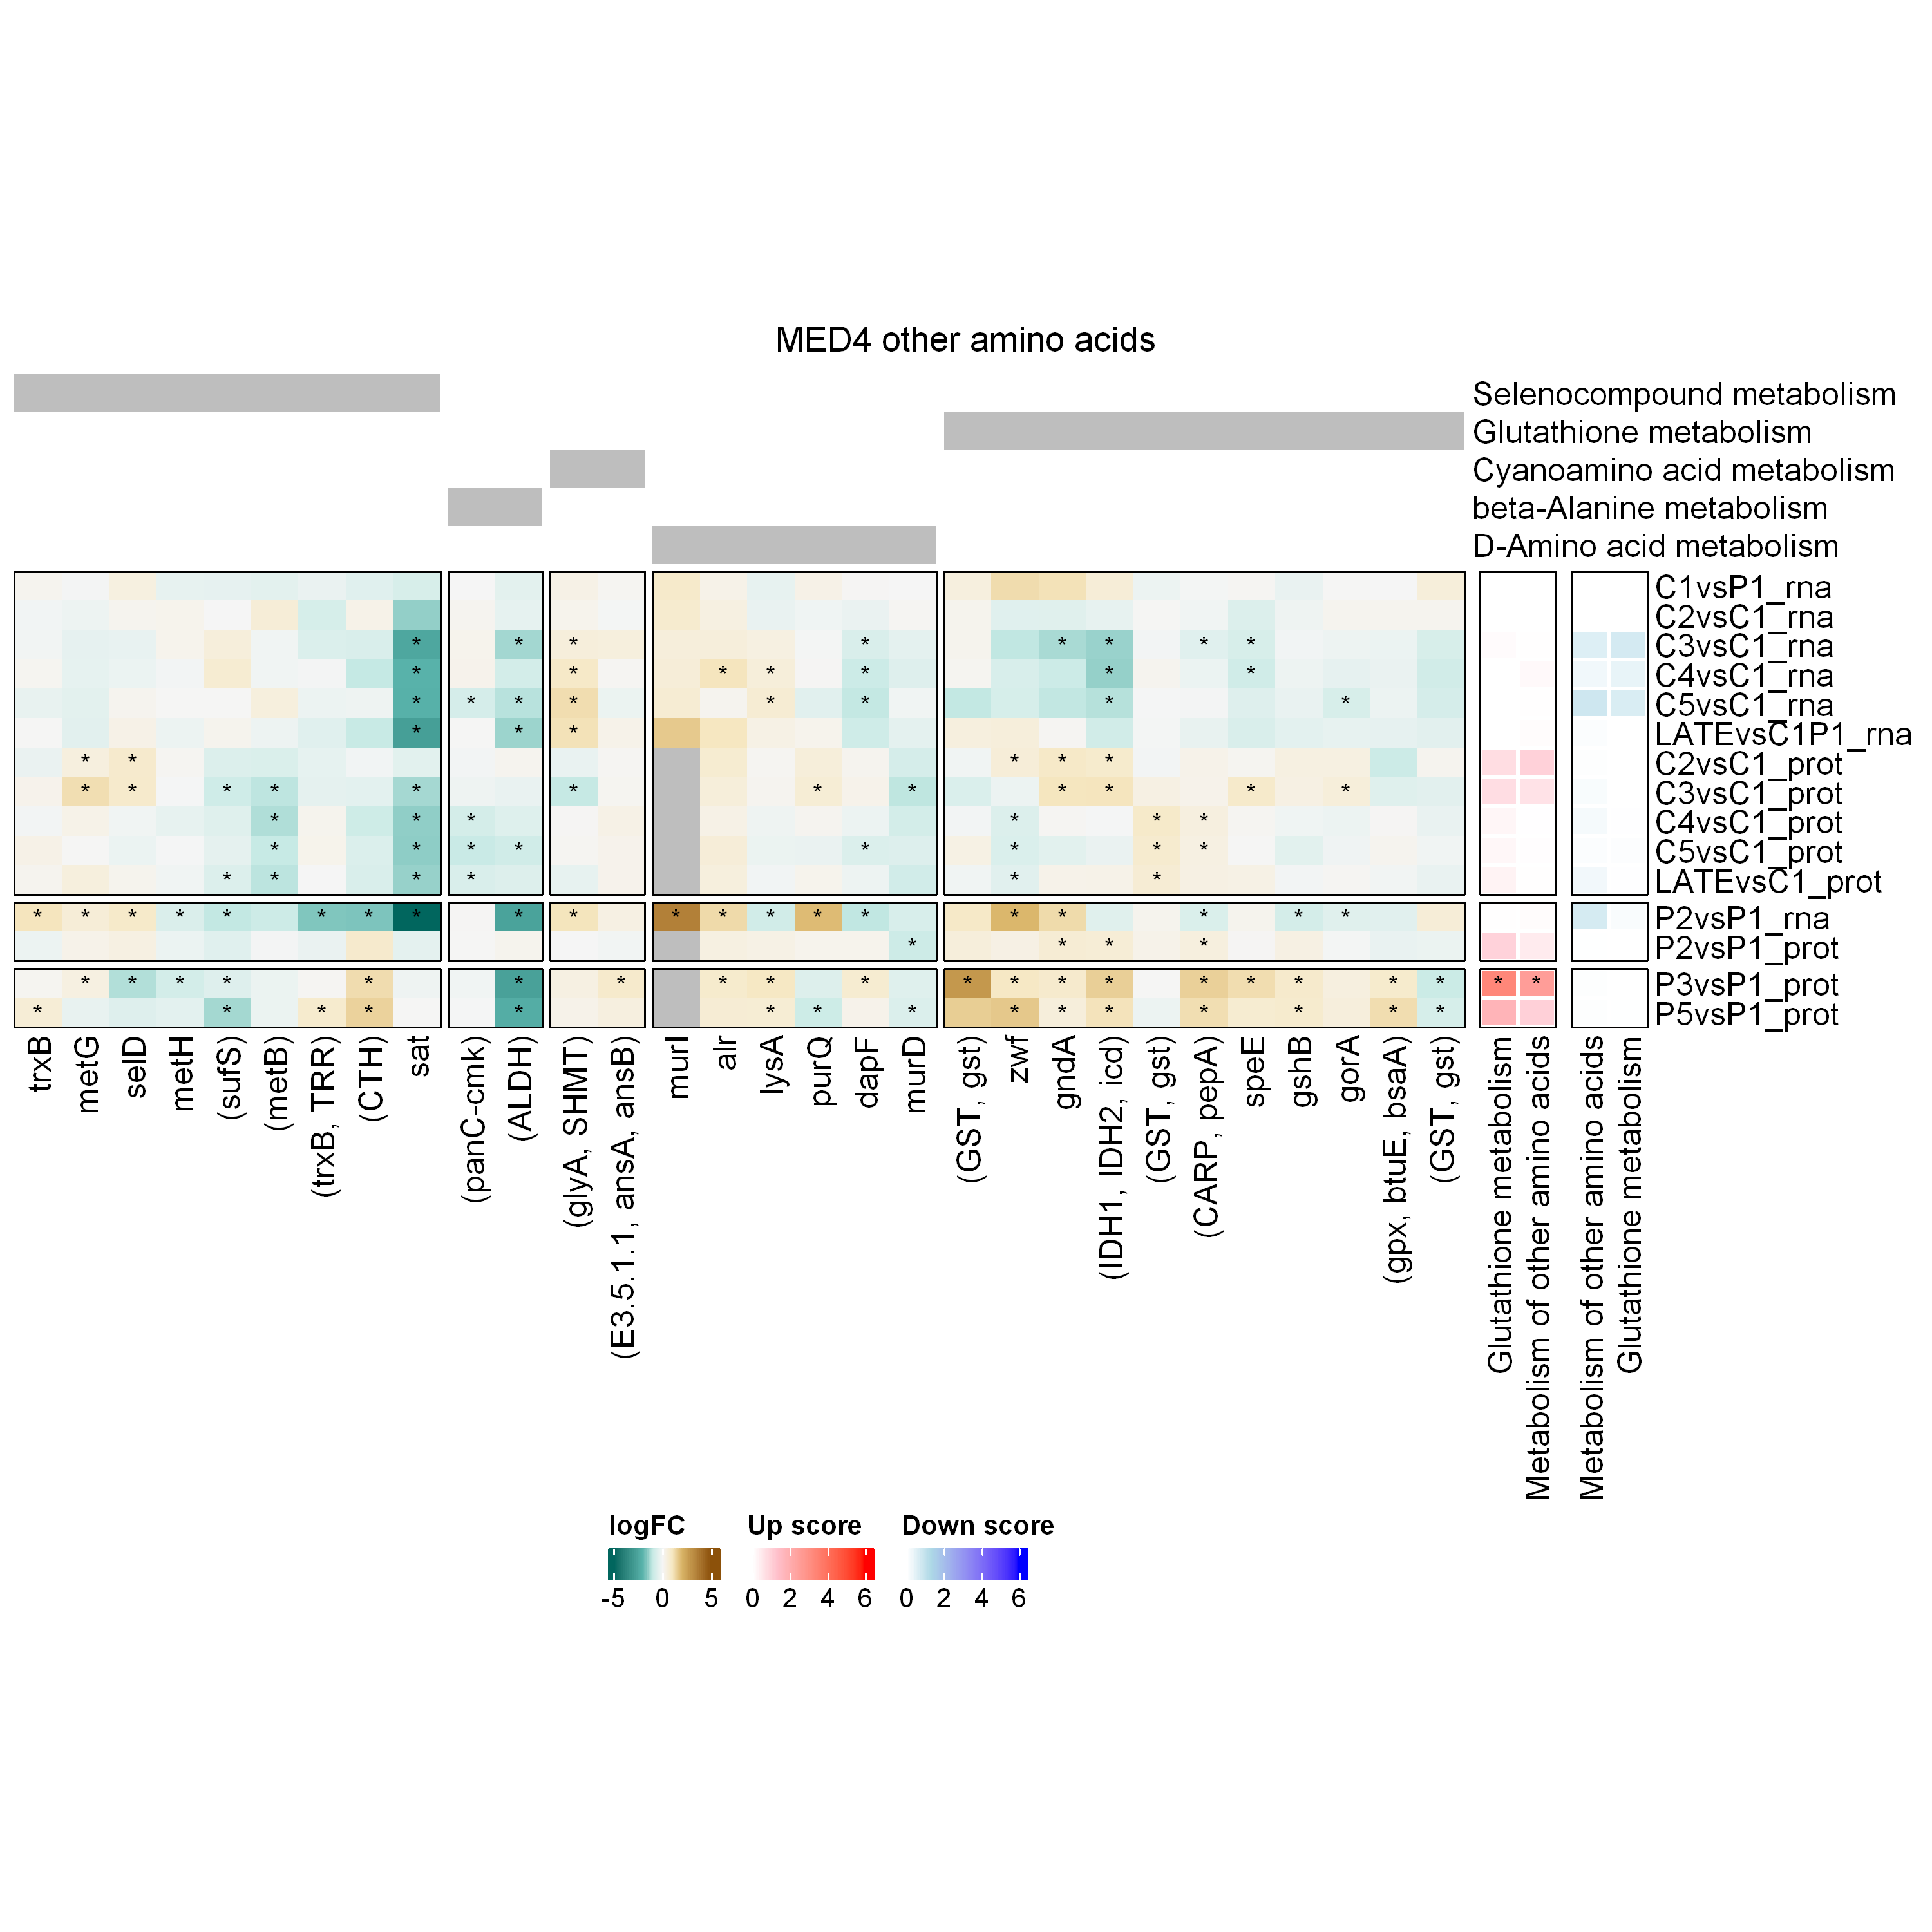

In [65]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## terpenoids and polyketides

In [66]:
module_name = 'terpenoids and polyketides'
module_title = paste0(genome, ' ',module_name)

In [67]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [68]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [69]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

gene         Carotenoid biosynthesis
TX50_RS00605 zds          Yes                    
TX50_RS00750 (crtB)       Yes                    
TX50_RS00755 pds          Yes                    
TX50_RS00920 (menF)       No                     
TX50_RS01215 (crtR)       Yes                    
TX50_RS01370 (ispH, lytB) No                     
             Biosynthesis of siderophore group nonribosomal peptides
TX50_RS00605 No                                                     
TX50_RS00750 No                                                     
TX50_RS00755 No                                                     
TX50_RS00920 Yes                                                    
TX50_RS01215 No                                                     
TX50_RS01370 No                                                     
             Terpenoid backbone biosynthesis Insect hormone biosynthesis
TX50_RS00605 No                              No                         
TX50_RS00750 No                              No                         
TX50_RS00755 No                              No                         
TX50_RS00920 No                              No                         
TX50_RS01215 No                              No                         
TX50_RS01370 Yes                             No                         
             Limonene and pinene degradation Polyketide sugar unit biosynthesis
TX50_RS00605 No                              No                                
TX50_RS00750 No                              No                                
TX50_RS00755 No                              No                                
TX50_RS00920 No                              No                                
TX50_RS01215 No                              No                                
TX50_RS01370 No                              No                                
             Biosynthesis of ansamycins
TX50_RS00605 No                        
TX50_RS00750 No                        
TX50_RS00755 No                        
TX50_RS00920 No                        
TX50_RS01215 No                        
TX50_RS01370 No                        
             Biosynthesis of vancomycin group antibiotics Zeatin biosynthesis
TX50_RS00605 No                                           No                 
TX50_RS00750 No                                           No                 
TX50_RS00755 No                                           No                 
TX50_RS00920 No                                           No                 
TX50_RS01215 No                                           No                 
TX50_RS01370 No                                           No

In [70]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


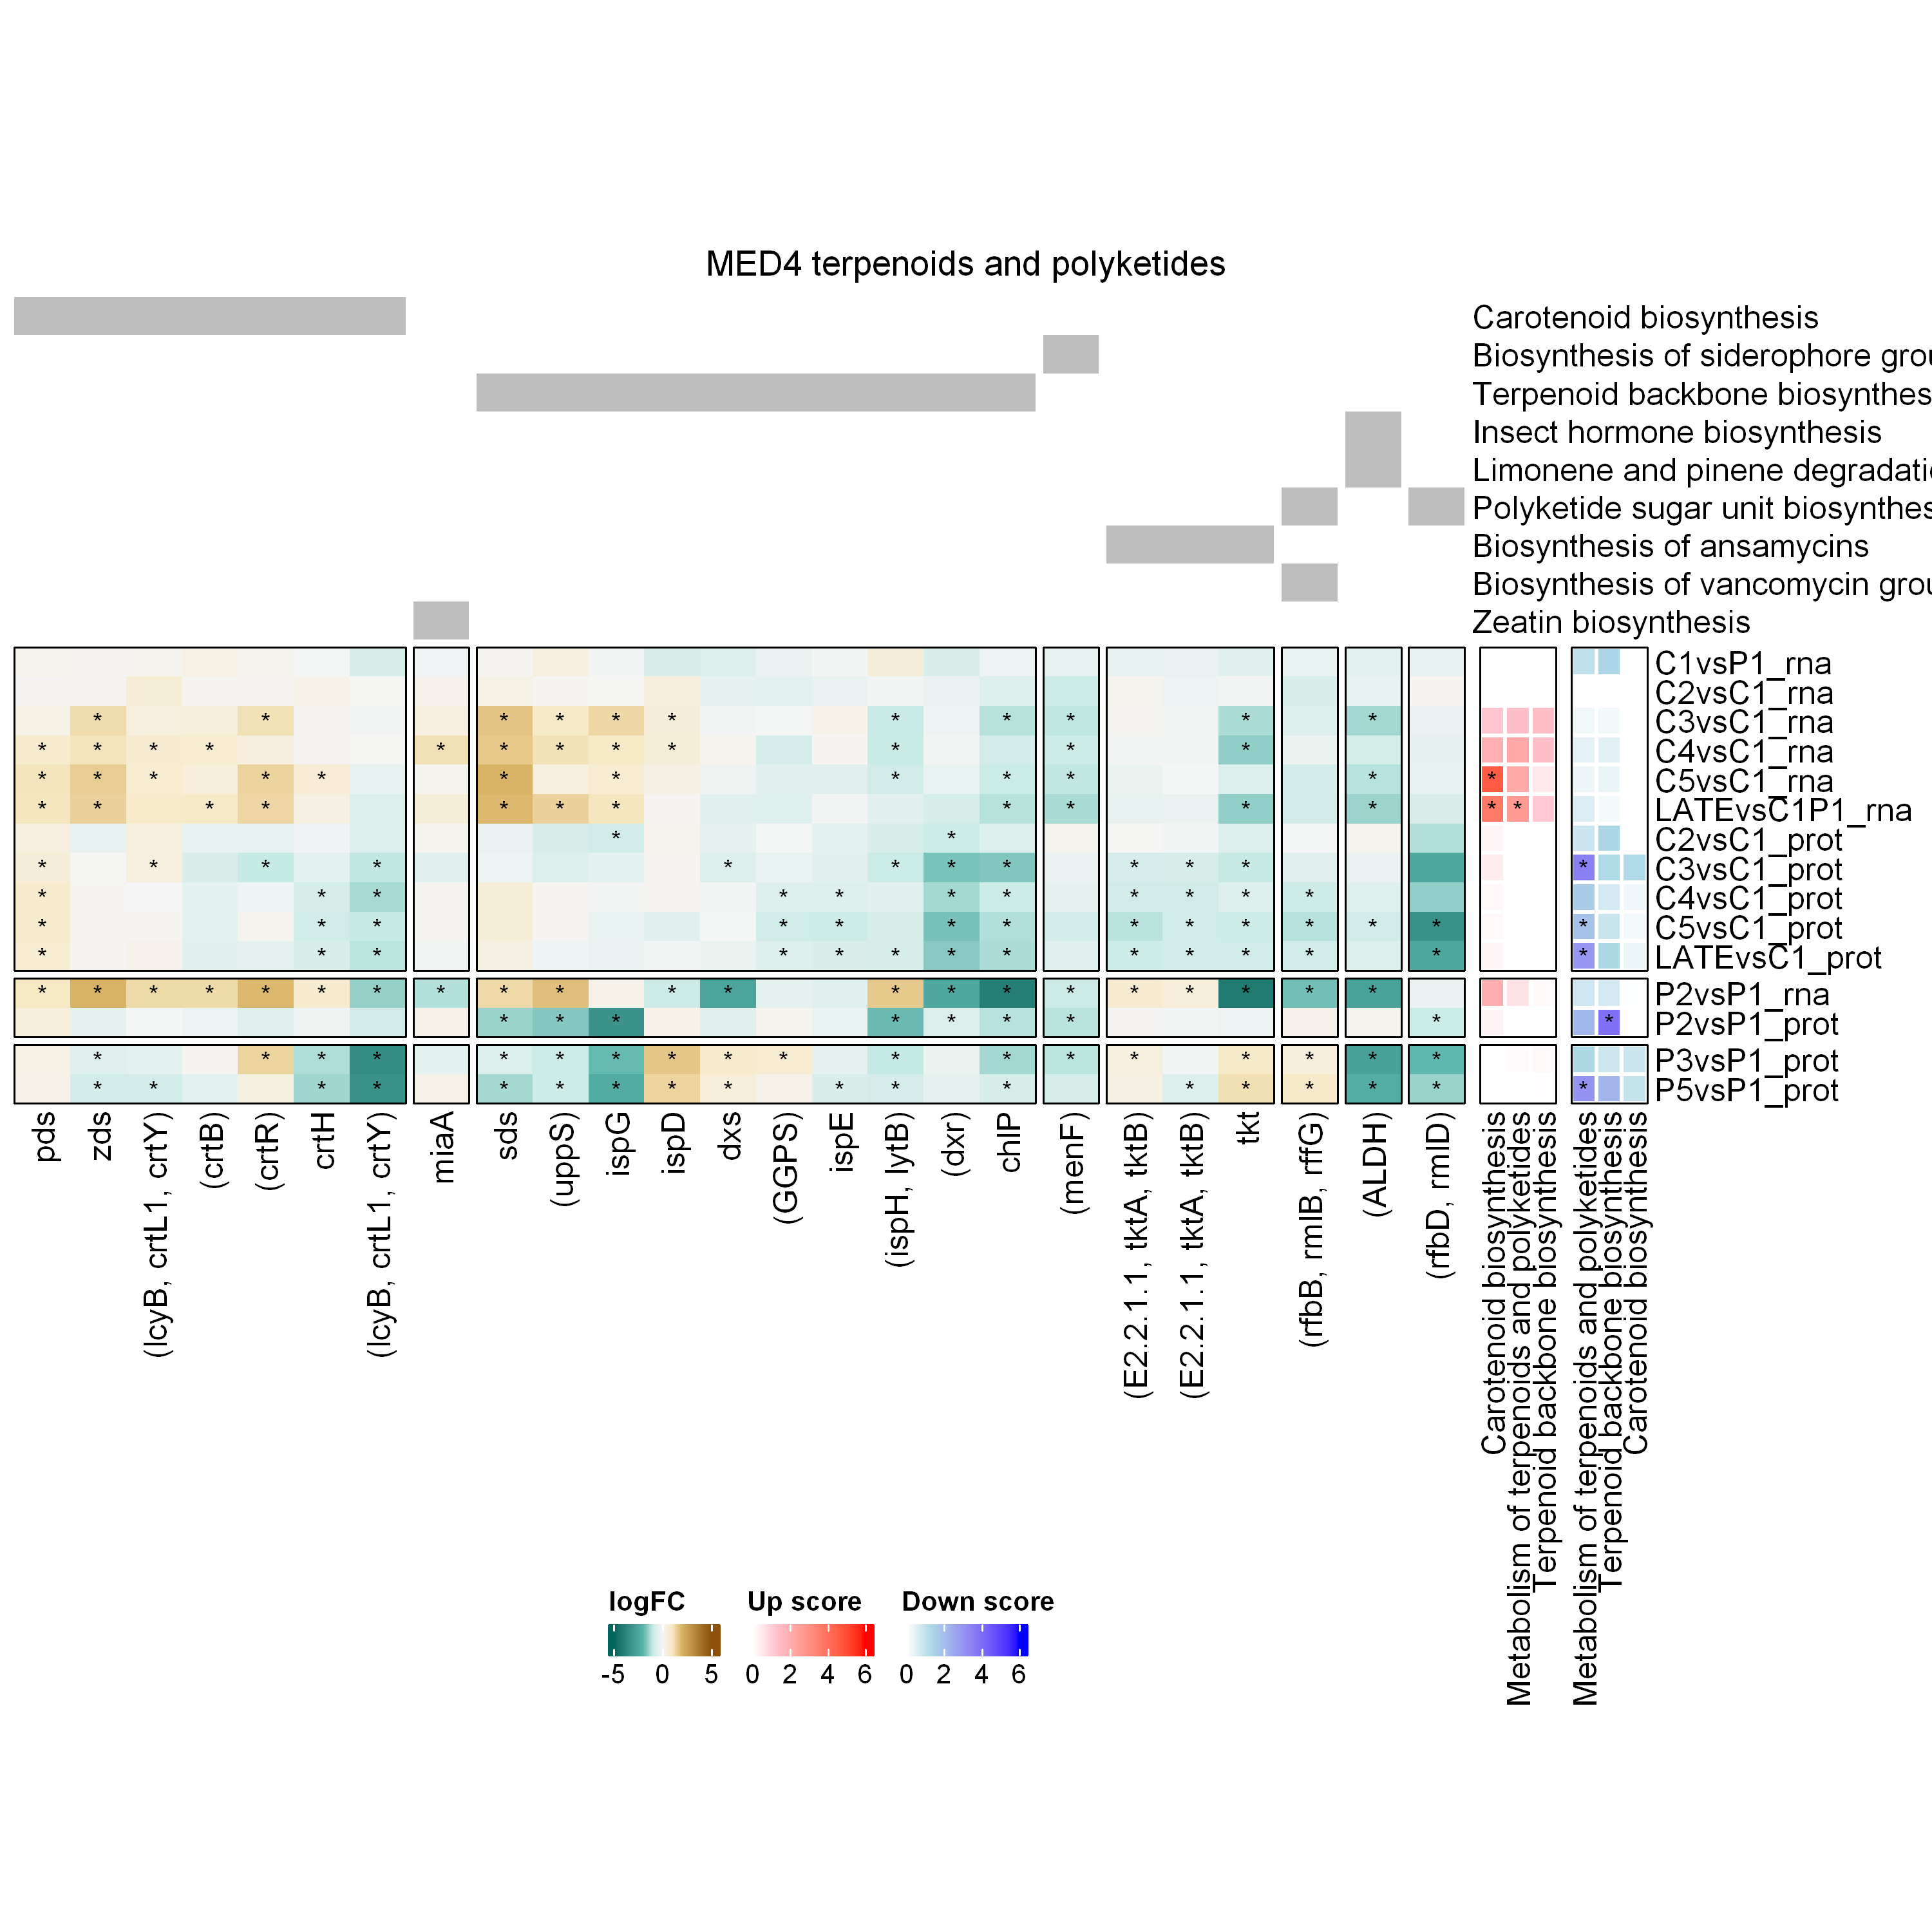

In [71]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## other secondary metabolites

In [72]:
module_name = 'other secondary metabolites'
module_title = paste0(genome, ' ',module_name)

In [73]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [74]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [75]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

gene                    Streptomycin biosynthesis
TX50_RS00405 (pgm)                   Yes                      
TX50_RS00510 (E3.1.3.25, IMPA, suhB) Yes                      
TX50_RS00720 fabD                    No                       
TX50_RS00955 (trpG)                  No                       
TX50_RS00965 (hisC)                  No                       
TX50_RS01170 sat                     No                       
             Prodigiosin biosynthesis Phenazine biosynthesis
TX50_RS00405 No                       No                    
TX50_RS00510 No                       No                    
TX50_RS00720 Yes                      No                    
TX50_RS00955 No                       Yes                   
TX50_RS00965 No                       No                    
TX50_RS01170 No                       No                    
             Tropane, piperidine and pyridine alkaloid biosynthesis
TX50_RS00405 No                                                    
TX50_RS00510 No                                                    
TX50_RS00720 No                                                    
TX50_RS00955 No                                                    
TX50_RS00965 Yes                                                   
TX50_RS01170 No                                                    
             Novobiocin biosynthesis Monobactam biosynthesis
TX50_RS00405 No                      No                     
TX50_RS00510 No                      No                     
TX50_RS00720 No                      No                     
TX50_RS00955 No                      No                     
TX50_RS00965 Yes                     No                     
TX50_RS01170 No                      Yes                    
             Glucosinolate biosynthesis
TX50_RS00405 No                        
TX50_RS00510 No                        
TX50_RS00720 No                        
TX50_RS00955 No                        
TX50_RS00965 No                        
TX50_RS01170 No                        
             Biosynthesis of various plant secondary metabolites
TX50_RS00405 No                                                 
TX50_RS00510 No                                                 
TX50_RS00720 No                                                 
TX50_RS00955 No                                                 
TX50_RS00965 No                                                 
TX50_RS01170 No                                                 
             Carbapenem biosynthesis
TX50_RS00405 No                     
TX50_RS00510 No                     
TX50_RS00720 No                     
TX50_RS00955 No                     
TX50_RS00965 No                     
TX50_RS01170 No                     
             Neomycin, kanamycin and gentamicin biosynthesis
TX50_RS00405 No                                             
TX50_RS00510 No                                             
TX50_RS00720 No                                             
TX50_RS00955 No                                             
TX50_RS00965 No                                             
TX50_RS01170 No                                             
             Isoquinoline alkaloid biosynthesis
TX50_RS00405 No                                
TX50_RS00510 No                                
TX50_RS00720 No                                
TX50_RS00955 No                                
TX50_RS00965 No                                
TX50_RS01170 No                                
             Acarbose and validamycin biosynthesis
TX50_RS00405 No                                   
TX50_RS00510 No                                   
TX50_RS00720 No                                   
TX50_RS00955 No                                   
TX50_RS00965 No                                   
TX50_RS01170 No                                   
             Biosynthesis of various antibiotics
TX50_RS00405 No                                 
TX50_RS00510 No               

In [76]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


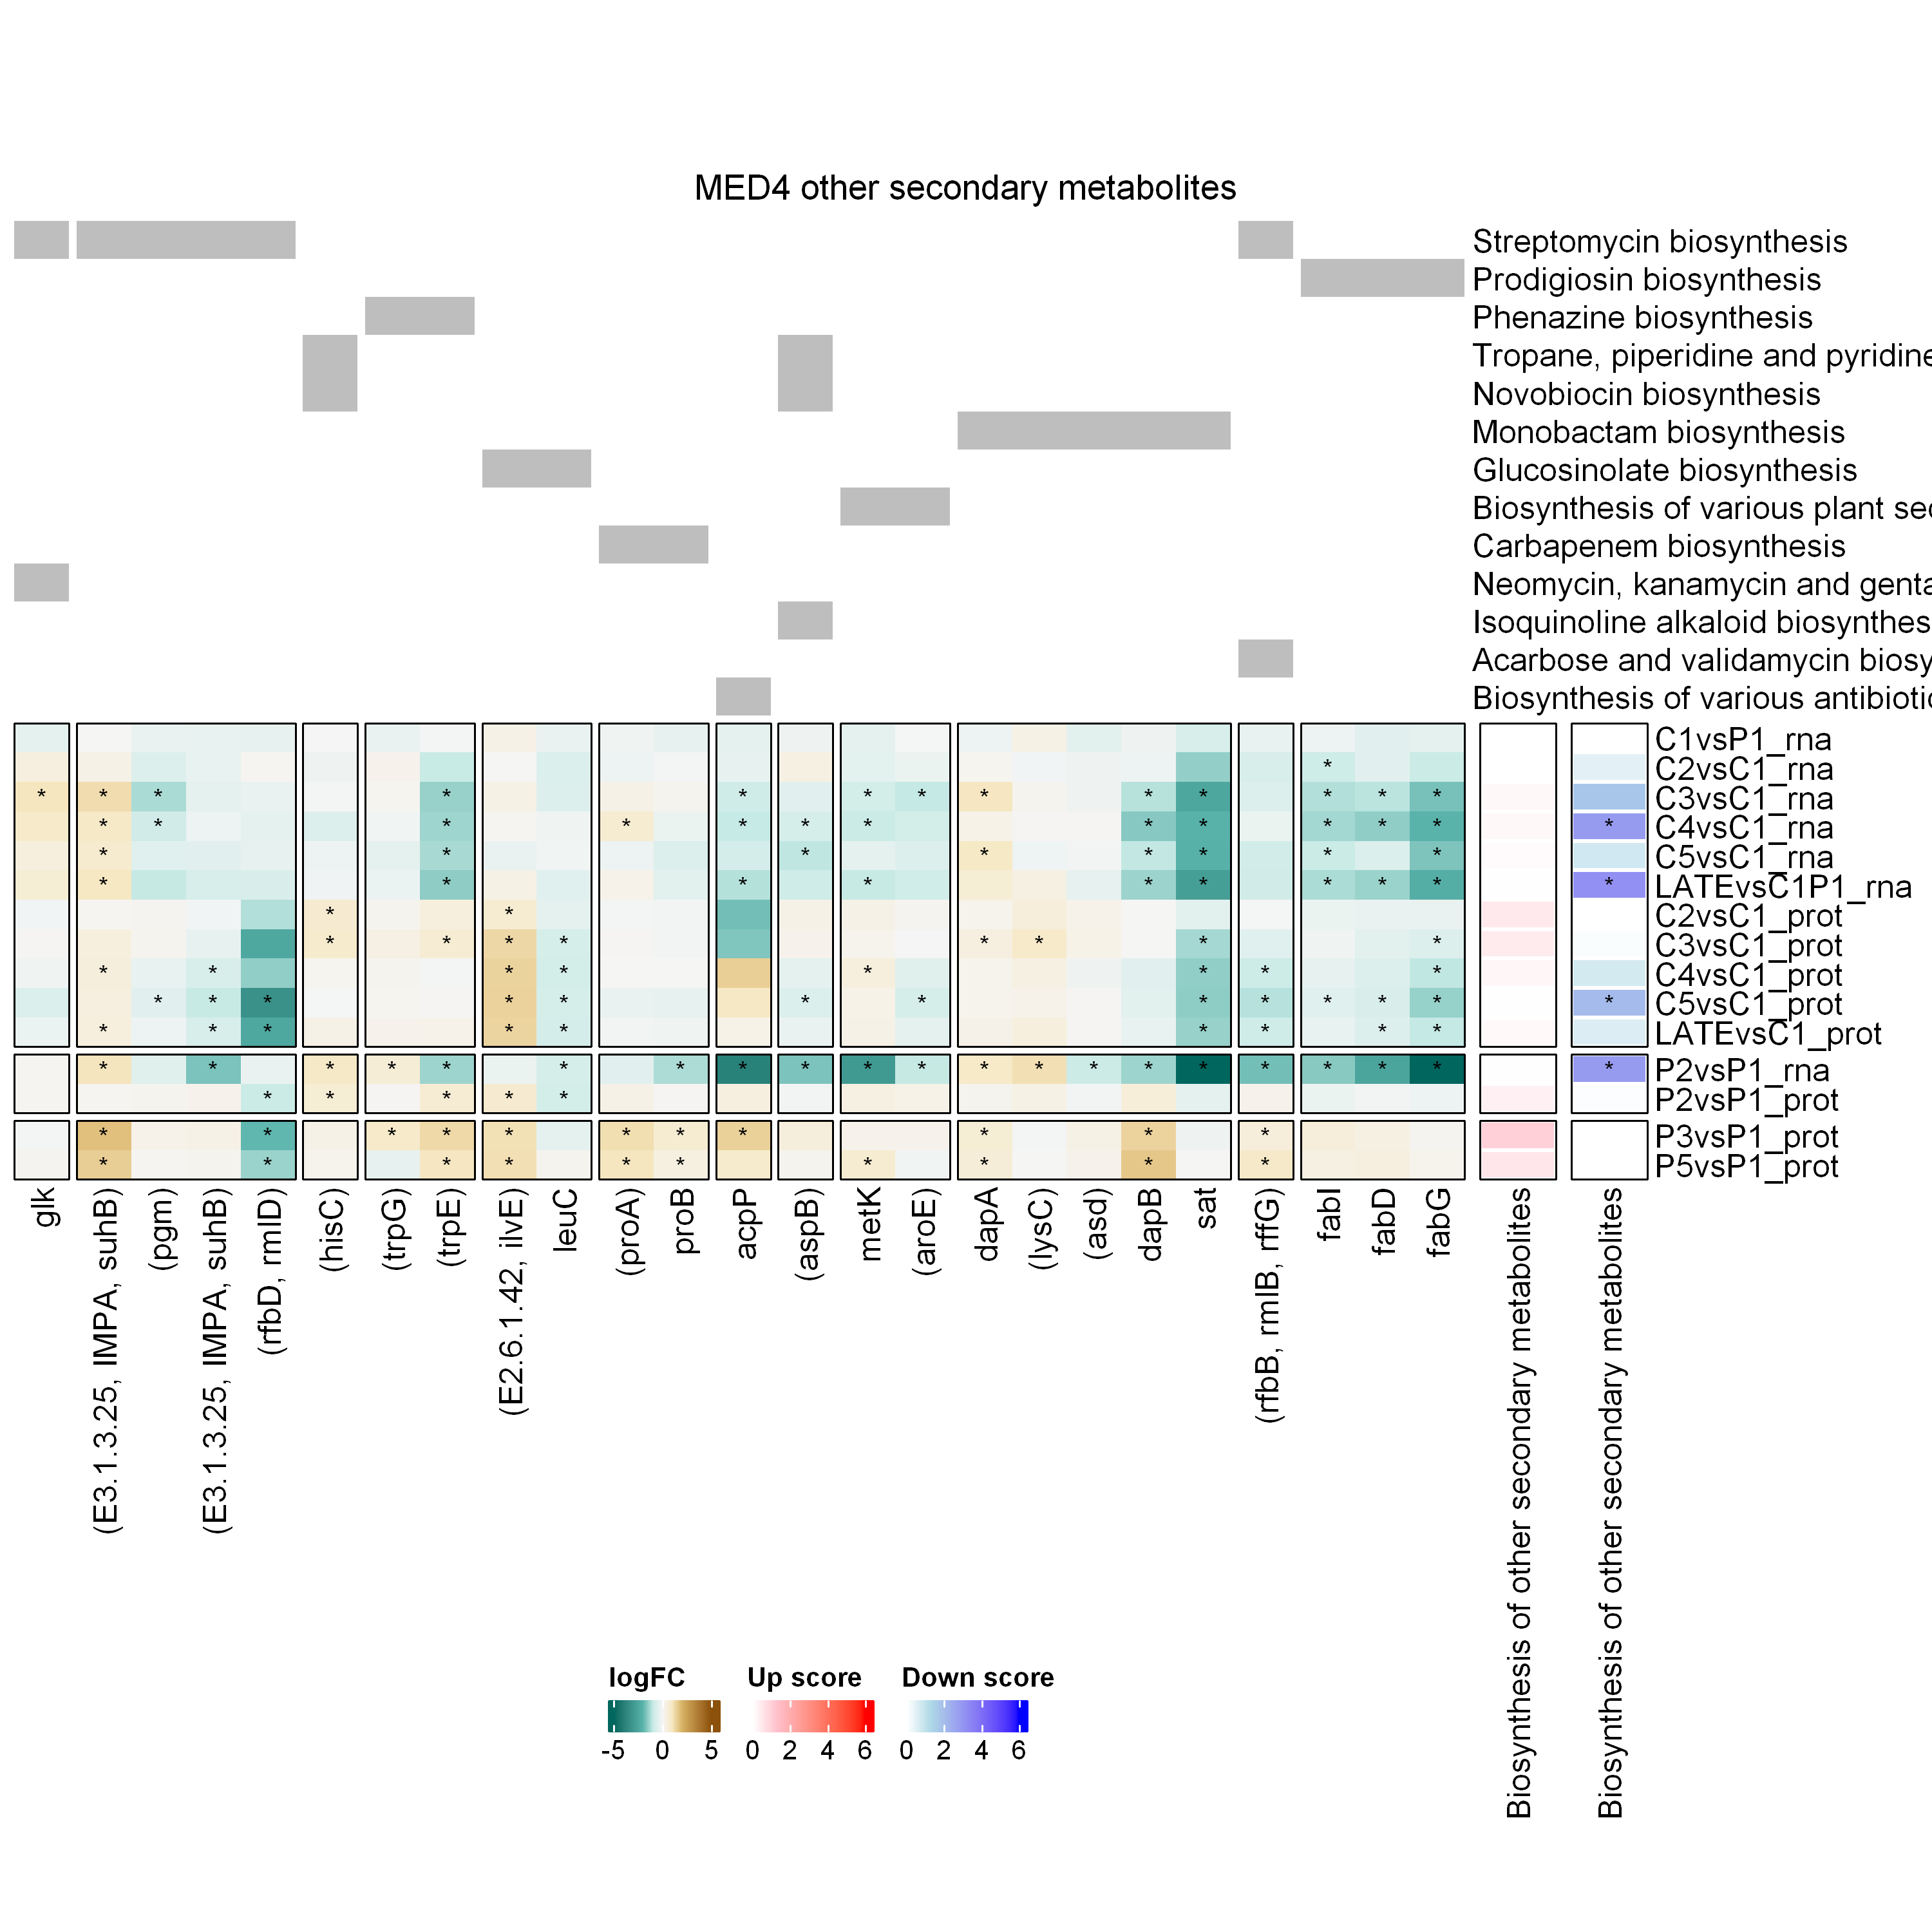

In [77]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Transporters

In [130]:
module_name = 'Membrane transport'
module_title = paste0(genome, ' ',module_name)

In [131]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [132]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [133]:
hpath_df %>% filter(module == 'Membrane transport') %>%
    extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; (.* system)", remove = FALSE) %>%
    mutate(system = if_else(str_detect(ecpath, 'preprotein translocase'), 'preprotein translocase', system)) %>%
    mutate(system = if_else(str_detect(ecpath, 'sec-independent protein translocase'), 'sec-independent protein translocase', system)) %>%
    count(system)
    #filter(is.na(system)) %>% distinct(ecpath)

system                                                       n
1  biotin transport system                                      1
2  energy-coupling factor transport system                      3
3  iron(III) transport system                                   3
4  lipopolysaccharide export system                             2
5  manganese transport system                                   3
6  nitrate/nitrite transport system                             3
7  phosphate transport system                                   4
8  phospholipid/cholesterol/gamma-HCH transport system          3
9  phosphonate transport system                                 4
10 preprotein translocase                                       6
11 sec-independent protein translocase                          3
12 urea transport system                                        5
13 vitamin B12/bleomycin/antimicrobial peptide transport system 1
14 NA                                                           5

In [147]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(module == 'Membrane transport') %>%
    extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; (.* system)", remove = FALSE) %>%
    mutate(system = if_else(str_detect(ecpath, 'preprotein translocase'), 'preprotein translocase', system)) %>%
    mutate(system = if_else(str_detect(ecpath, 'sec-independent protein translocase'), 'sec-independent protein translocase', system)) %>%
    mutate(system = str_replace(system, " translocase", "")) %>%
    mutate(system = str_replace(system, " transport system", "")) %>%
    mutate(system = if_else(is.na(system), '', system)) %>%

    distinct(gene_id, gene, system) %>%
    #mutate(value_col = 'Yes') %>%
    #pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'system', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
#gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

gene              system                                     
TX50_RS00065 ftsY                                                         
TX50_RS00345 (bacA, bclA)      vitamin B12/bleomycin/antimicrobial peptide
TX50_RS00655 (ecfA1)           energy-coupling factor                     
TX50_RS01065 secE              preprotein                                 
TX50_RS01500 (mlaD, linM)      phospholipid/cholesterol/gamma-HCH         
TX50_RS01505 (mlaF, linL, mkl) phospholipid/cholesterol/gamma-HCH

In [144]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


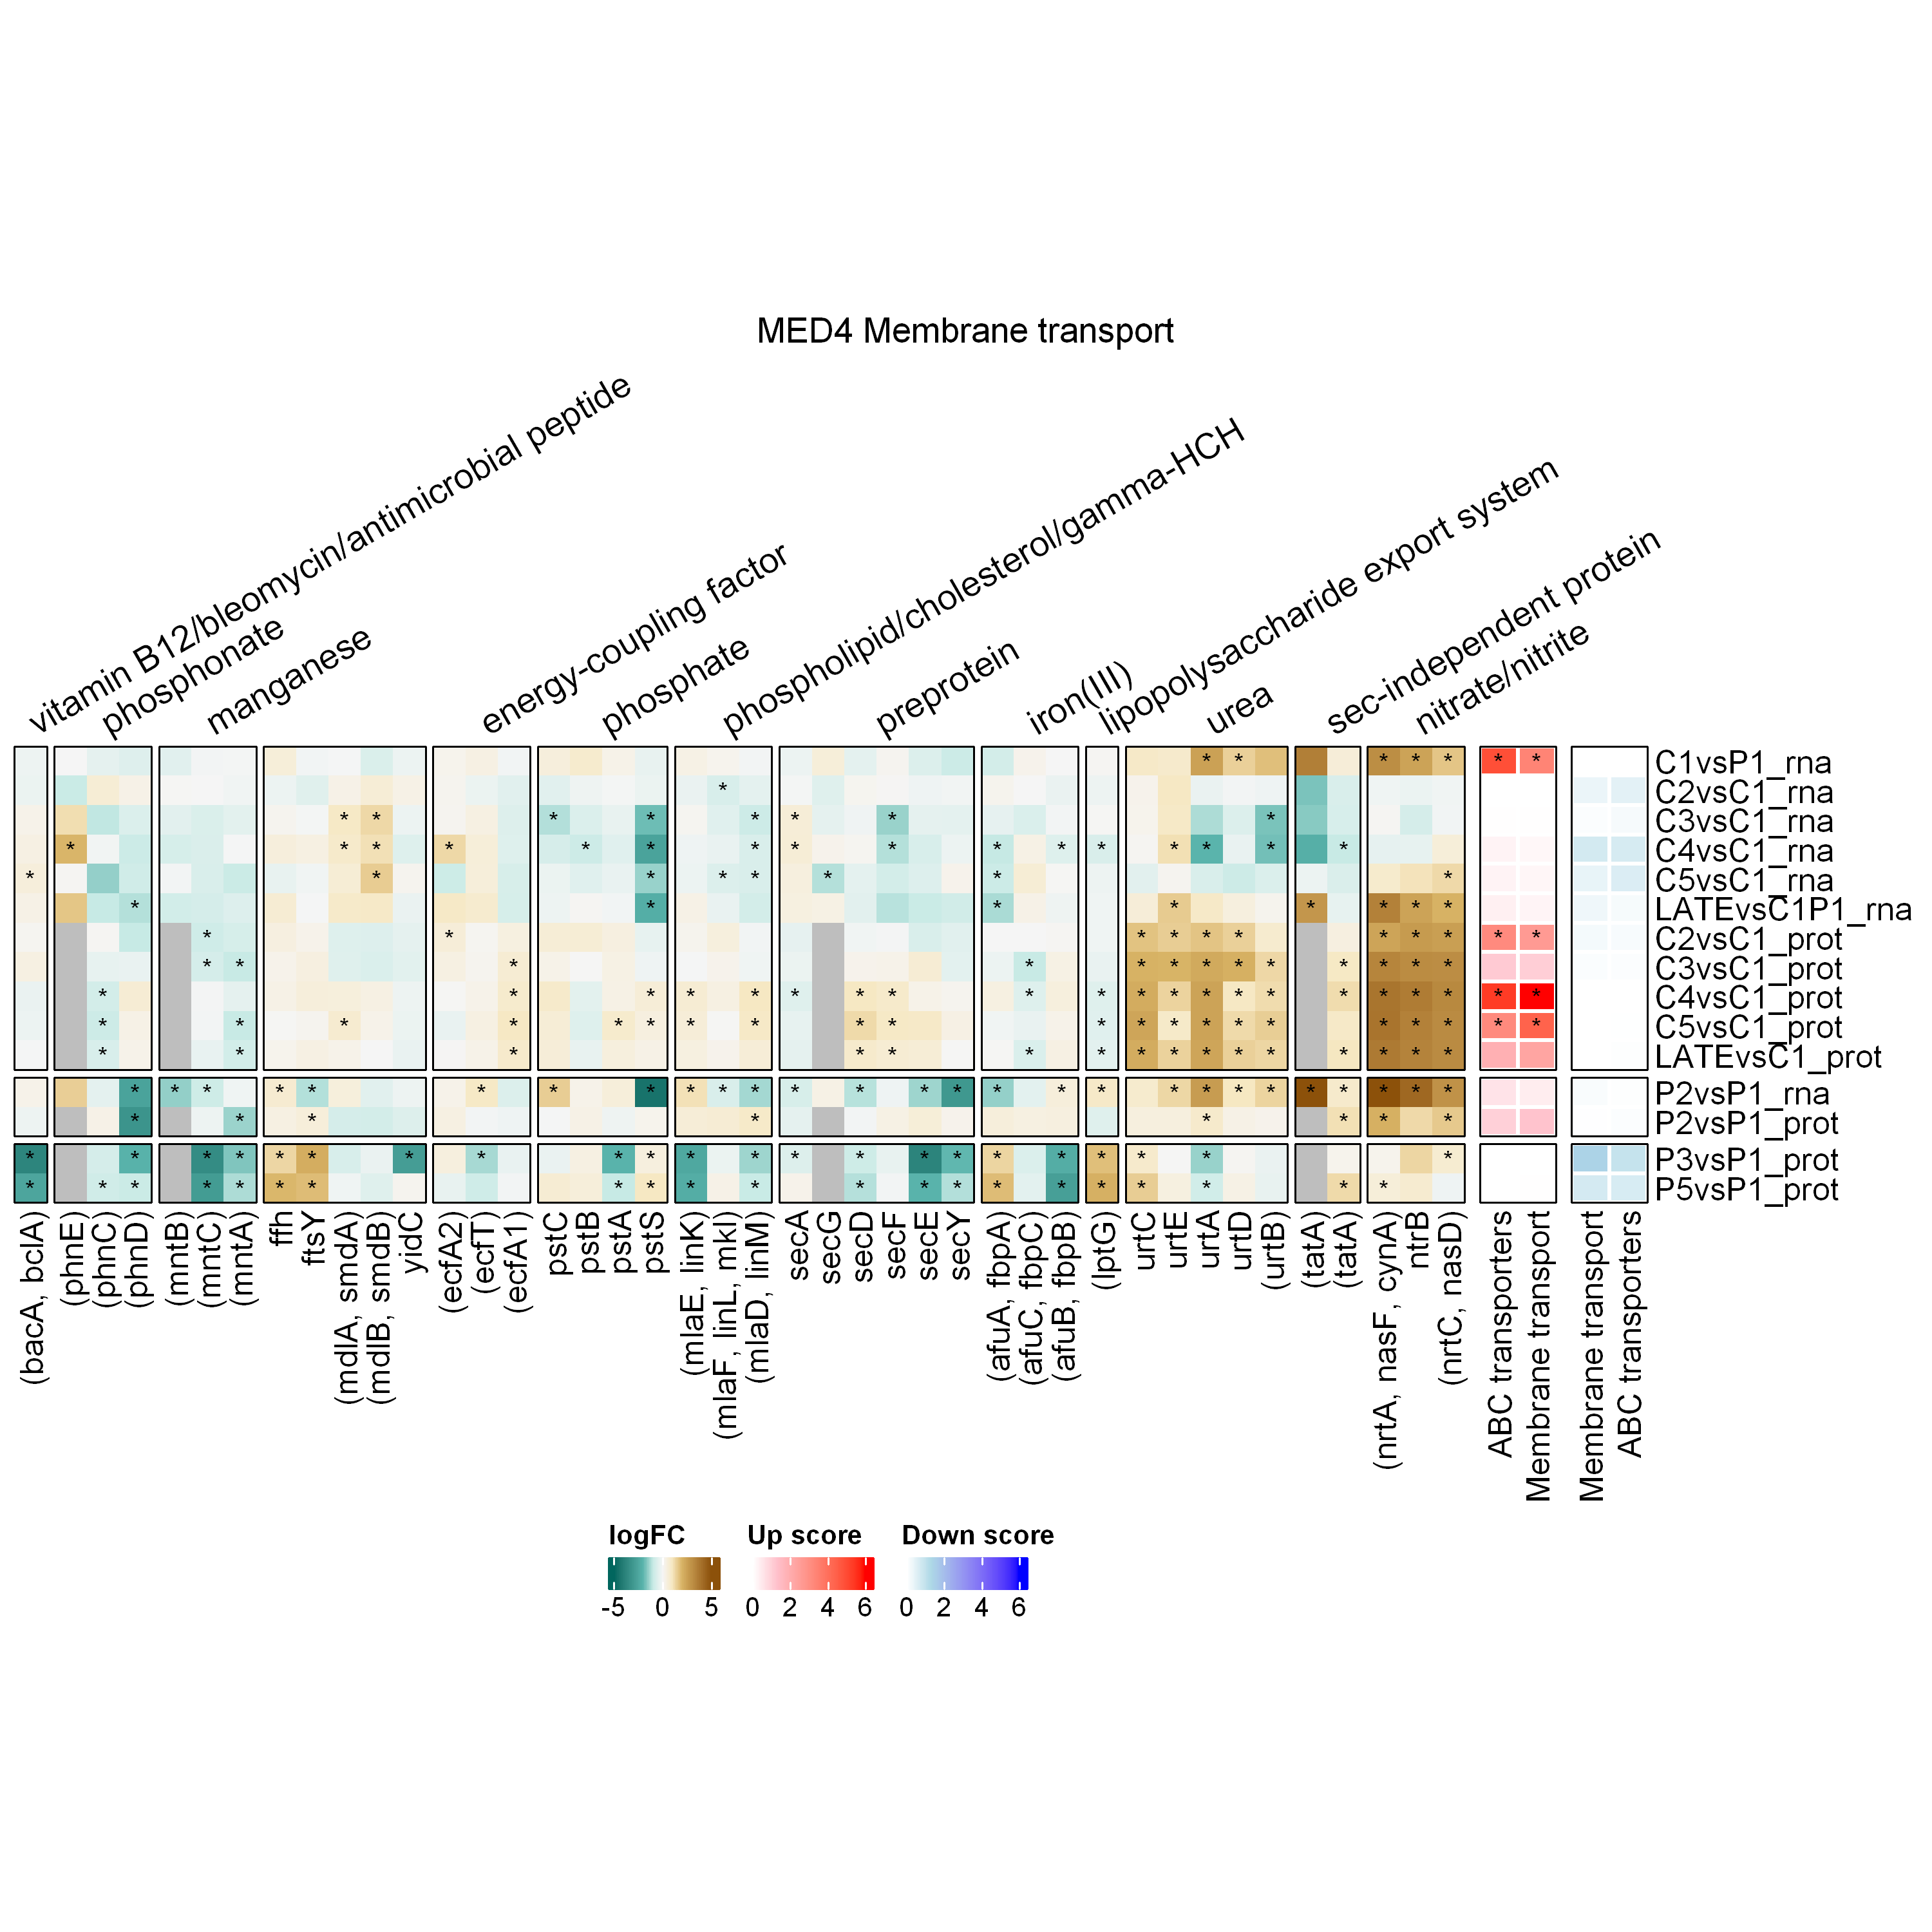

In [149]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     #column_title=NULL,
    column_split = gene_meta$system,
    #column_title_gp = gpar(fontsize = 15),    
    column_title_rot = 30,
    column_labels=gene_meta$gene,
#     top_annotation = HeatmapAnnotation(
#         Pathway=gene_meta$system, 
#         #show_legend =FALSE,
#         #col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
#         #show_legend=FALSE,
#     ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [153]:
paste0(unique(gene_meta$system), collapse = ' , ')

[1] " , vitamin B12/bleomycin/antimicrobial peptide , energy-coupling factor , preprotein , phospholipid/cholesterol/gamma-HCH , sec-independent protein , nitrate/nitrite , iron(III) , manganese , phosphonate , phosphate , urea , lipopolysaccharide export system"

## Lipid

In [84]:
module_name = 'Lipid'
module_title = paste0(genome, ' ',module_name)

In [85]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [86]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [87]:
gene_meta = hpath_df %>% 
    filter(str_detect(sub, module_name)) %>%
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

gene   Fatty acid biosynthesis Glycerolipid metabolism
TX50_RS00150 accB   Yes                     No                     
TX50_RS00320 accC   Yes                     No                     
TX50_RS00710 plsX   No                      Yes                    
TX50_RS00715 (fabH) Yes                     No                     
TX50_RS00720 fabD   Yes                     No                     
TX50_RS00725 (plsC) No                      Yes                    
             Glycerophospholipid metabolism Fatty acid degradation
TX50_RS00150 No                             No                    
TX50_RS00320 No                             No                    
TX50_RS00710 No                             No                    
TX50_RS00715 No                             No                    
TX50_RS00720 No                             No                    
TX50_RS00725 Yes                            No                    
             Arachidonic acid metabolism
TX50_RS00150 No                         
TX50_RS00320 No                         
TX50_RS00710 No                         
TX50_RS00715 No                         
TX50_RS00720 No                         
TX50_RS00725 No

In [88]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


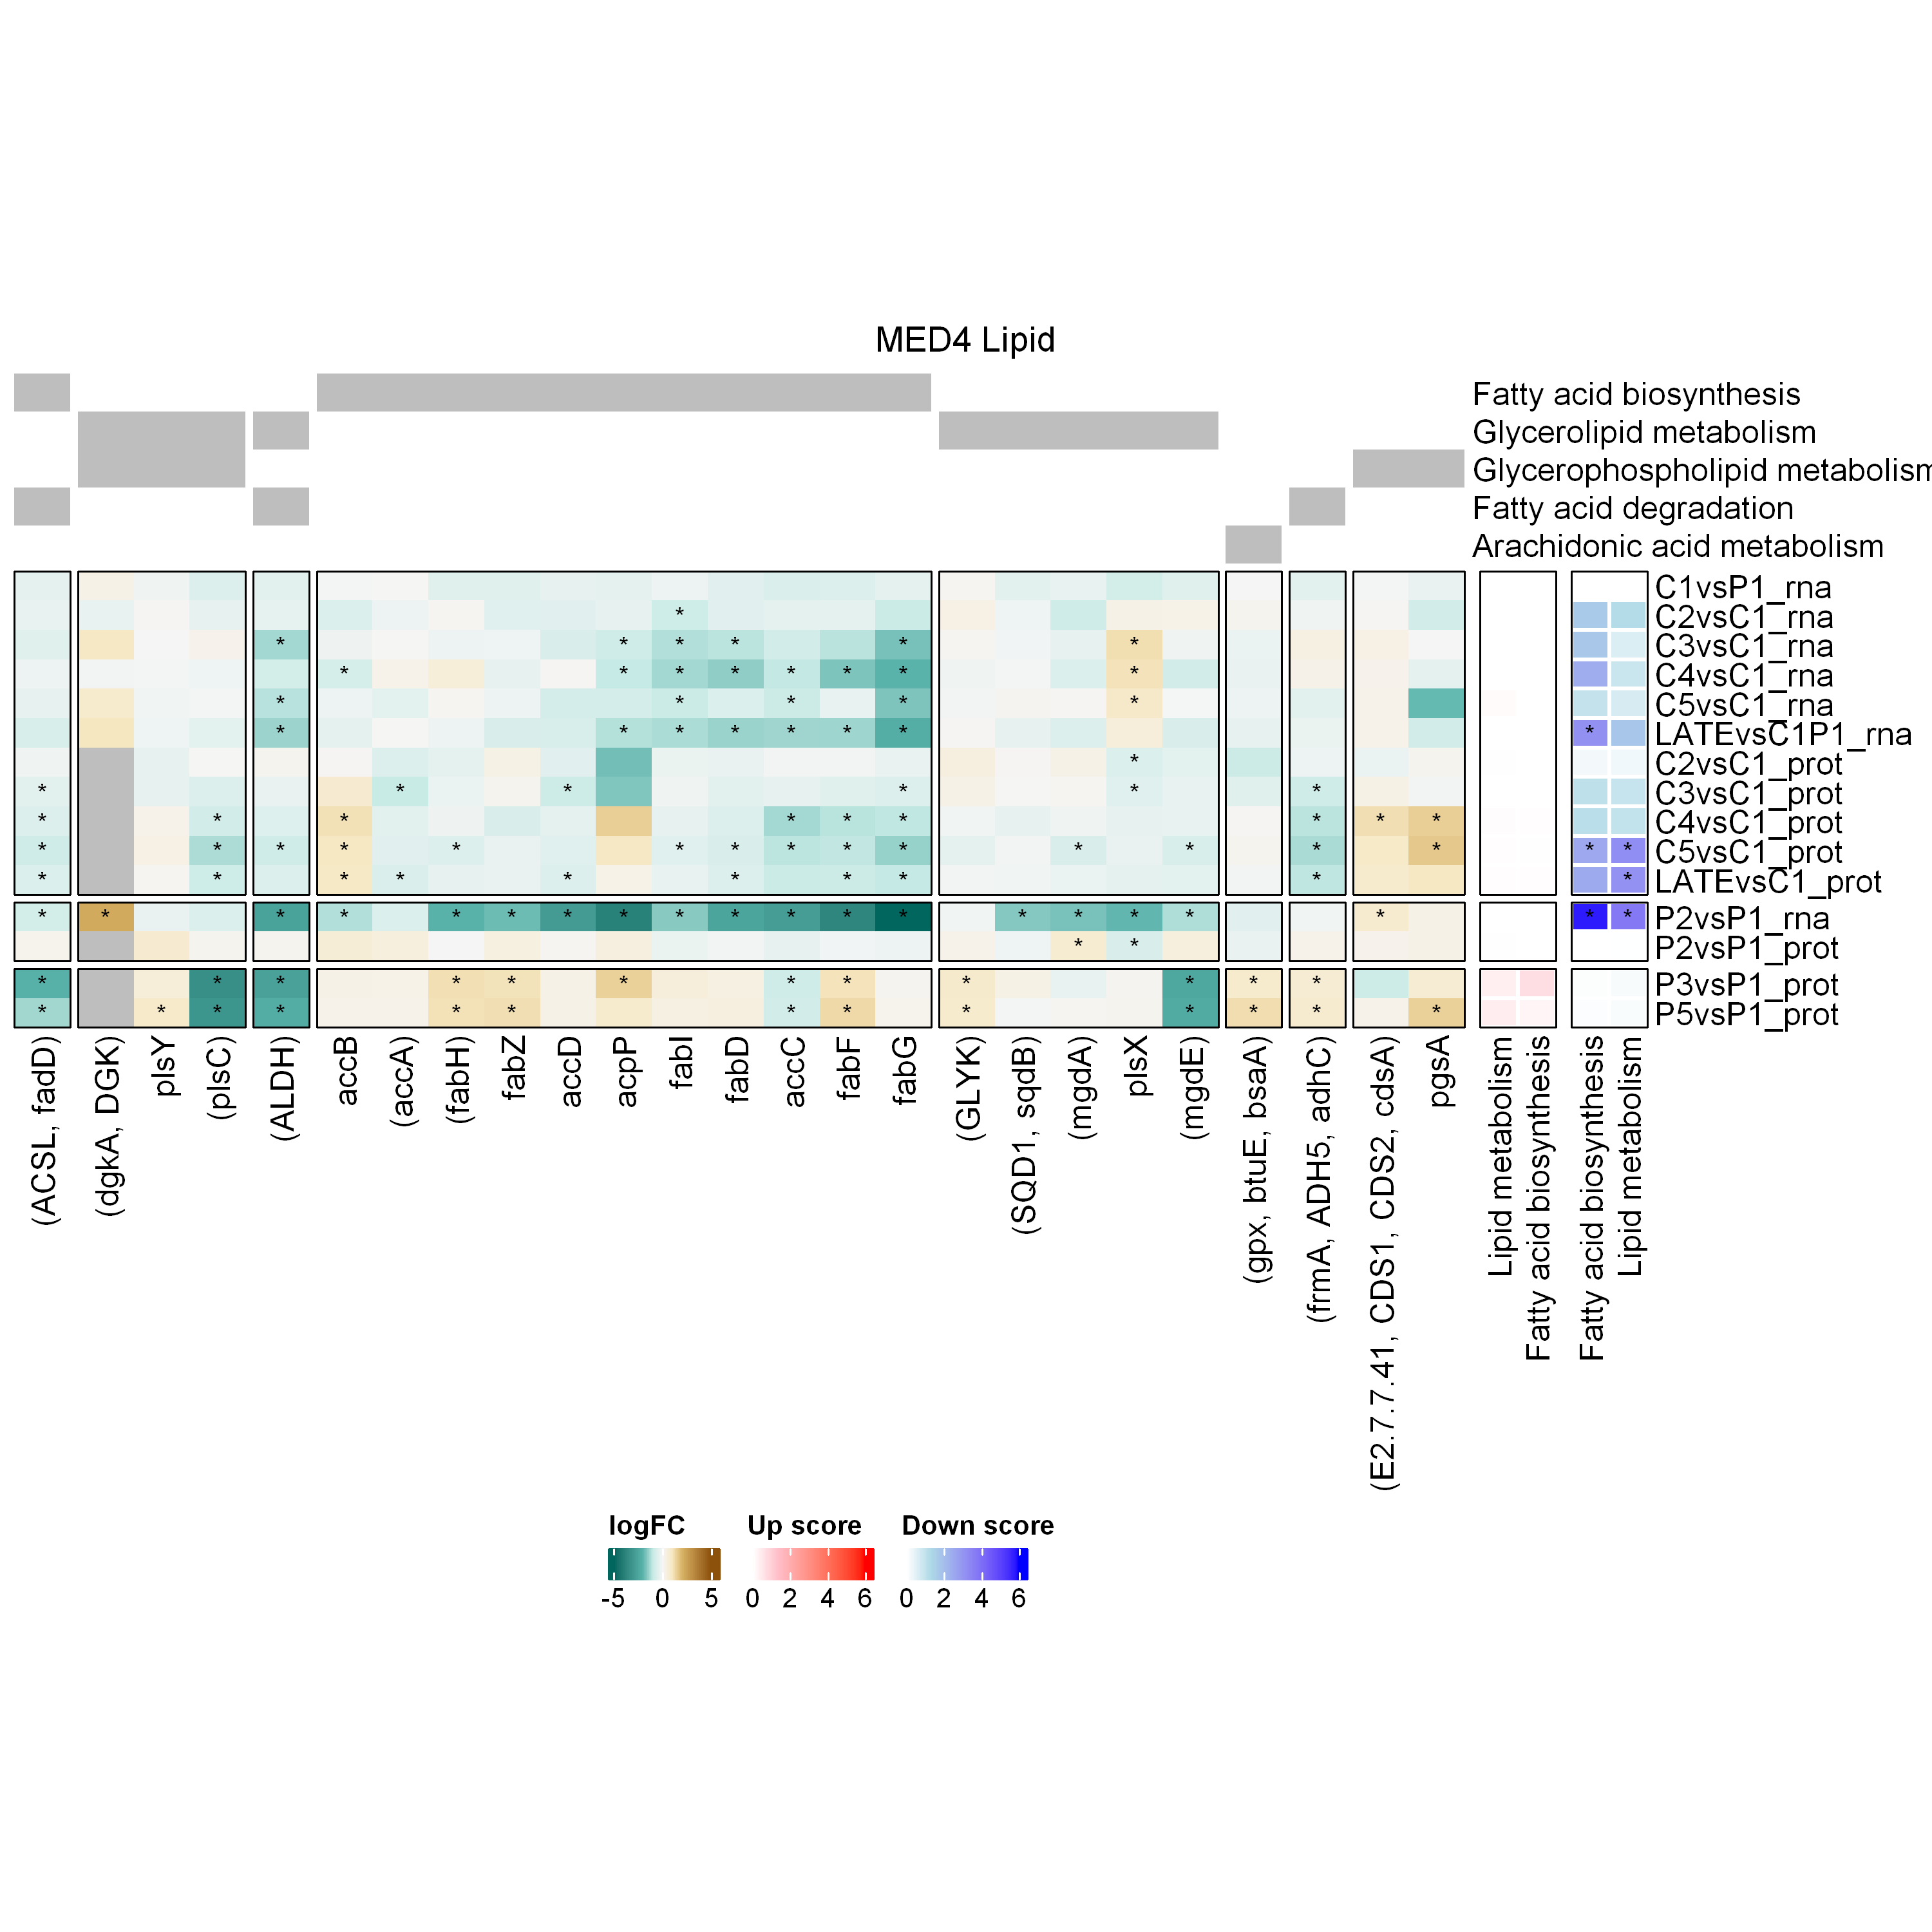

In [89]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Amino acid

In [90]:
module_name = 'Amino acid'
module_title = paste0(genome, ' ',module_name)

In [91]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)

In [92]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [93]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [94]:
gene_stars

TX50_RS00150 TX50_RS00320 TX50_RS00710 TX50_RS00715 TX50_RS00720
C1vsP1_rna                                                                     
C2vsC1_rna                                                                     
C3vsC1_rna                               *                         *           
C4vsC1_rna     *            *            *                         *           
C5vsC1_rna                  *            *                                     
LATEvsC1P1_rna              *                                      *           
C2vsC1_prot                              *                                     
C3vsC1_prot                              *                                     
C4vsC1_prot    *            *                                                  
C5vsC1_prot    *            *                         *            *           
LATEvsC1_prot  *                                                   *           
P2vsP1_rna     *            *            *            *            *           
P2vsP1_prot                              *                                     
P3vsP1_prot                 *                         *                        
P5vsP1_prot                 *                         *                        
               TX50_RS00725 TX50_RS00950 TX50_RS01465 TX50_RS01745 TX50_RS02160
C1vsP1_rna                                                                     
C2vsC1_rna                               *                                     
C3vsC1_rna                               *            *                        
C4vsC1_rna                               *                                     
C5vsC1_rna                               *            *                        
LATEvsC1P1_rna                           *            *                        
C2vsC1_prot                                                                    
C3vsC1_prot                                                        *           
C4vsC1_prot    *                                                   *           
C5vsC1_prot    *                         *            *            *           
LATEvsC1_prot  *                                                   *           
P2vsP1_rna                  *            *            *            *           
P2vsP1_prot                                                                    
P3vsP1_prot    *                                      *            *           
P5vsP1_prot    *                                      *            *           
               ⋯ TX50_RS05105 TX50_RS05380 TX50_RS05825 TX50_RS06645
C1vsP1_rna     ⋯                                                    
C2vsC1_rna     ⋯                                                    
C3vsC1_rna     ⋯                                                    
C4vsC1_rna     ⋯                                                    
C5vsC1_rna     ⋯                                                    
LATEvsC1P1_rna ⋯                                                    
C2vsC1_prot    ⋯                                                    
C3vsC1_prot    ⋯                                        *           
C4vsC1_prot    ⋯                           *            *           
C5vsC1_prot    ⋯                                        *           
LATEvsC1_prot  ⋯                                        *           
P2vsP1_rna     ⋯                           *                        
P2vsP1_prot    ⋯                                                    
P3vsP1_prot    ⋯ *            *                         *           
P5vsP1_prot    ⋯ *            *                         *           
               TX50_RS07125 TX50_RS07170 TX50_RS08605 TX50_RS08610 TX50_RS08865
C1vsP1_rna                                                                     
C2vsC1_rna                                                                     
C3vsC1_rna                               *                                     
C4vsC1_rna                     

In [95]:
pathwaylist

pathway                                    
1 Amino sugar and nucleotide sugar metabolism
2 Glycolysis / Gluconeogenesis               
3 Pentose phosphate pathway                  
4 Citrate cycle (TCA cycle)                  
5 Glyoxylate and dicarboxylate metabolism

In [96]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [97]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


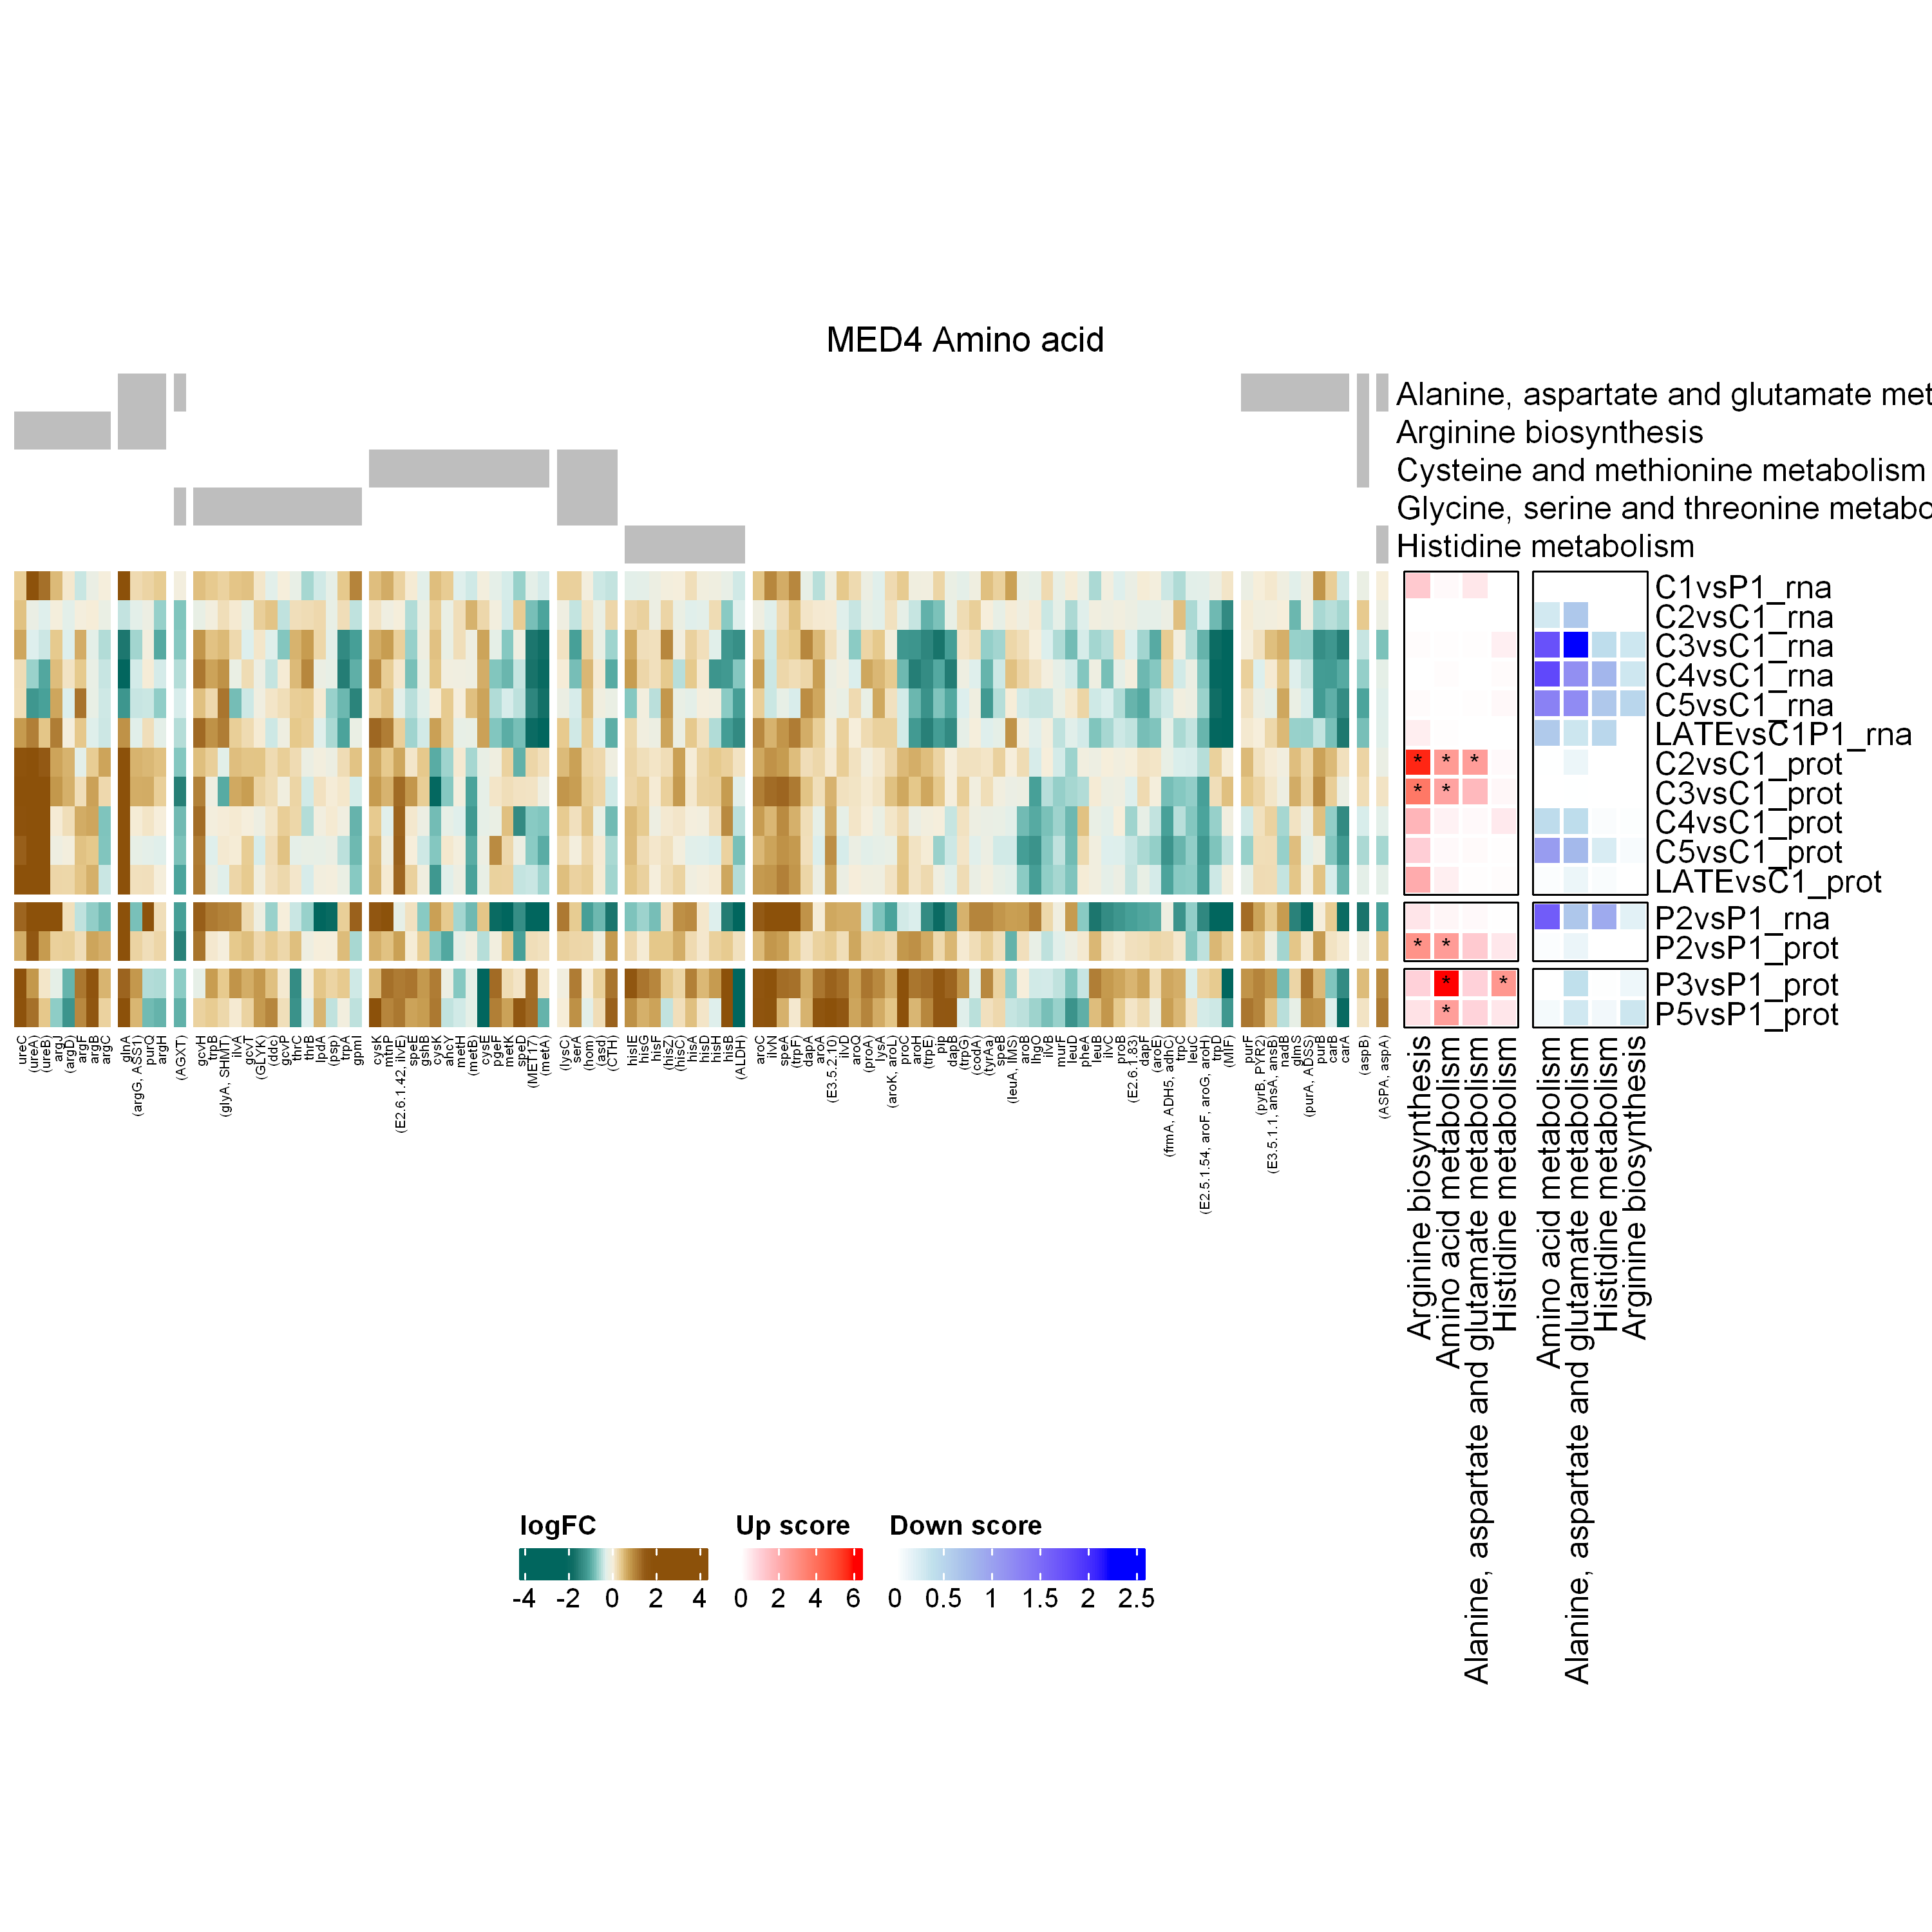

In [98]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=pupgoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=pdowngoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = pfcgoseq,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
#     cell_fun = function(j, i, x, y, width, height, fill) {
#         grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
#     },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [100]:
head(df_all)

contrast gene_id      logFC      AveExpr    pvalue       padj        
1 C2 - C1  TX50_RS01980  2.6029332  0.9167156 5.951467e-07 0.0004868287
2 C2 - C1  TX50_RS05125  1.7956460  2.0464881 8.763244e-07 0.0004868287
3 C2 - C1  TX50_RS09075  1.1167539  1.4678595 1.025622e-06 0.0004868287
4 C2 - C1  TX50_RS05175  1.4380690 -0.2070244 2.486196e-06 0.0008850858
5 C2 - C1  TX50_RS08845 -0.9884268  3.7497430 3.186503e-06 0.0009075161
6 C2 - C1  TX50_RS01985  1.7087460 -0.2557767 5.226353e-06 0.0012403878
  Assay    contrast1   Length down  ⋯ X    path_id
1 Proteome C2vsC1_prot  852   FALSE ⋯  549 K15578 
2 Proteome C2vsC1_prot 1707   FALSE ⋯ 1437 K01428 
3 Proteome C2vsC1_prot 2571   FALSE ⋯ 2496 K01682 
4 Proteome C2vsC1_prot  753   FALSE ⋯ 1455 K11962 
5 Proteome C2vsC1_prot 1419    TRUE ⋯ 2421 K03545 
6 Proteome C2vsC1_prot  441   FALSE ⋯  552 K01725 
  main                                                                               
1 09100 Metabolism;09130 Environmental Information Processing;09180 Brite Hierarchies
2 09100 Metabolism;09160 Human Diseases                                              
3 09100 Metabolism                                                                   
4 09130 Environmental Information Processing;09180 Brite Hierarchies                 
5 09190 Not Included in Pathway or Brite                                             
6 09100 Metabolism                                                                   
  sub                                                                                                                                        
1 09102 Energy metabolism;09131 Membrane transport;09183 Protein families: signaling and cellular processes                                  
2 09104 Nucleotide metabolism;09105 Amino acid metabolism;09111 Xenobiotics biodegradation and metabolism;09171 Infectious disease: bacterial
3 09101 Carbohydrate metabolism;09102 Energy metabolism                                                                                      
4 09131 Membrane transport;09183 Protein families: signaling and cellular processes                                                          
5 09192 Unclassified: genetic information processing                                                                                         
6 09102 Energy metabolism                                                                                                                    
  module                                                                            
1 Energy;Membrane transport;Protein families: signaling and cellular processes      
2 Nucleotide;Amino acid;Xenobiotics biodegradation and;Infectious disease: bacterial
3 Carbohydrate;Energy                                                               
4 Membrane transport;Protein families: signaling and cellular processes             
5 Unclassified: genetic information processing                                      
6 Energy                                                                            
  path                                                                                                                                                                                                               
1 00910 Nitrogen metabolism [PATH:ko00910];02010 ABC transporters [PATH:ko02010];02000 Transporters [BR:ko02000]                                                                                                     
2 00230 Purine metabolism [PATH:ko00230];00220 Arginine biosynthesis [PATH:ko00220];00791 Atrazine degradation [PATH:ko00791];05120 Epithelial cell signaling in Helicobacter pylori infection [PATH:ko05120]        
3 00020 Citrate cycle (TCA cycle) [PATH:ko00020];00630 Glyoxylate and dicarboxylate metabolism [PATH:ko00630];00640 Propanoate metabolism [PATH:ko00640];00720 Carbon fixation pathways in prokaryotes [PATH:ko00720]
4 02010 ABC transporters [PATH:ko02010];02000 Transporters [BR:ko02000]                       

In [101]:
write.csv(df_all, 't.csv')

In [108]:
df_all %>% 
    filter(padj < 0.05) %>% 
    mutate(direction = if_else(logFC >0 , 'UP', 'DOWN')) %>%
    filter(str_detect(contrast1, 'C1')) %>%
    select('direction', "gene_id", "gene", "product", "ecpath",
"module",  "pathway",  ) %>%
    distinct(direction, gene_id, .keep_all = TRUE) %>%
write.csv('de_genes.csv')
           


In [102]:
dput(names(df_all))

c("contrast", "gene_id", "logFC", "AveExpr", "pvalue", "padj", 
"Assay", "contrast1", "Length", "down", "up", "gene", "product", 
"protein_id", "old_locus_tag", "X", "path_id", "main", "sub", 
"module", "path", "pathway", "ecpath", "kegg_gene", "prev_gene"
)


In [99]:
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.14.0       ggrepel_0.9.3              
 [3] ComplexUpset_1.3.3          viridis_0.6.2              
 [5] viridisLite_0.4.1           circlize_0.4.15            
 [7] corrplot_0.92               pheatmap_1.0.12            
 [9] lubridate_1.9.2             forcats_1.0.0              
[11] stringr_1.5.0               dplyr_1.1.0                
[13] purrr_1.0.1                 readr_2.1.4                
[15] tidyr_1.3.0                 tibble_3.1.8               
[17] tidyverse_2.0.0             rea